In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import matplotlib.dates  as mdates

from datetime   import datetime, timezone
from legendmeta import LegendMetadata

from itertools import cycle

lmeta = LegendMetadata('/Users/romoluque_c/Repositories/legend-metadata/')

In [3]:
run_dict = {'p03':{'r000':{},'r001':{},'r002':{},'r003':{},'r004':{},'r005':{}},
            'p04':{'r000':{},'r001':{},'r002':{},'r003':{}},
            'p06':{'r000':{},'r001':{},'r002':{},'r003':{},'r004':{},'r005':{}},
            'p07':{          'r001':{},'r002':{},'r003':{},'r004':{},'r005':{},'r006':{},'r007':{}}}
            #'p08':{          'r001':{},'r002':{},'r003':{},'r004':{},'r005':{},'r006':{}}}

In [4]:
data_path = '/Users/romoluque_c/LEGEND/Energy_scale_group/Partitioning/data_example/'

In [5]:
dt    = datetime(2023, 4, 22, 5, 54, 22, tzinfo=timezone.utc)
chmap = lmeta.hardware.configuration.channelmaps.on(dt)
channel_dict = {}
for channel_name, channel_data in chmap.items():
    try:
        channel_dict[channel_data['daq']['rawid']] = (lmeta.channelmap(dt)[channel_name].type,
                                                      channel_name,
                                                      lmeta.channelmap(dt)[channel_name].production['mass_in_g'],
                                                      lmeta.channelmap(dt)[channel_name].location  ['string'],
                                                      lmeta.channelmap(dt)[channel_name].location  ['position'])
    except:
        continue

In [6]:
channel_dict;

In [7]:
for key, value in channel_dict.items():
    if value[0]== 'icpc':
        print(key, value)
for key, value in channel_dict.items():
    if value[0]== 'bege':
        print(key, value)
for key, value in channel_dict.items():
    if value[0]== 'coax':
        print(key, value)
for key, value in channel_dict.items():
    if value[0]== 'ppc':
        print(key, value)

1104000 ('icpc', 'V02160A', 1750.0, 1, 1)
1104001 ('icpc', 'V02160B', 1719.0, 1, 2)
1104002 ('icpc', 'V05261B', 2393.0, 1, 3)
1104003 ('icpc', 'V05266A', 2073.0, 1, 4)
1104004 ('icpc', 'V05266B', 1988.0, 1, 5)
1104005 ('icpc', 'V05268B', 1791.0, 1, 6)
1105600 ('icpc', 'V05612A', 2201.0, 1, 7)
1105602 ('icpc', 'V07647A', 1893, 1, 8)
1105603 ('icpc', 'V07647B', 1779, 1, 9)
1108802 ('icpc', 'V00074A', 2073.0, 2, 7)
1108803 ('icpc', 'V04549A', 1943.0, 2, 8)
1108804 ('icpc', 'V07298B', 2085, 2, 9)
1115200 ('icpc', 'V01386A', 1510.9, 4, 8)
1115201 ('icpc', 'V01403A', 1422.5, 4, 9)
1115202 ('icpc', 'V01404A', 1548.5, 4, 10)
1115203 ('icpc', 'V01406A', 1382.6, 4, 11)
1115204 ('icpc', 'V01415A', 1596.2, 4, 12)
1116801 ('icpc', 'V08682B', 1517, 5, 1)
1116802 ('icpc', 'V08682A', 3340, 5, 2)
1116803 ('icpc', 'V09372A', 4046, 5, 3)
1116804 ('icpc', 'V09374A', 2648, 5, 4)
1116805 ('icpc', 'V09724A', 2643, 5, 5)
1118402 ('icpc', 'V02162B', 2480.0, 7, 1)
1118403 ('icpc', 'V02166B', 2634.0, 7, 2)
11184

In [8]:
def cal_energy(e_uncal, cal_pars):
    if len(cal_pars.keys())==2:
        #print('lin')
        return cal_pars['a'] * e_uncal + cal_pars['b'], 'lin'
    elif len(cal_pars.keys())==3:
        #print('quad')
        return cal_pars['a'] * e_uncal **2 + cal_pars['b'] * e_uncal + cal_pars['c'], 'quad'

In [9]:
def uncal_quad(e_cal, cal_pars):
    return (-cal_pars['b']+np.sqrt(cal_pars['b']**2-2*cal_pars['a']*(cal_pars['c']-e_cal)))/(2*cal_pars['a'])

### Let's choose all the ICPC detectors

In [10]:
all_params_ch = {}
all_channels  = ['ch1104000', 'ch1104001', 'ch1104002', 'ch1104003', 'ch1104004', 'ch1104005', 'ch1105600',
                 'ch1105602', 'ch1105603', 'ch1108802', 'ch1108803', 'ch1108804', 'ch1115200', 'ch1115201',
                 'ch1115202', 'ch1115203', 'ch1115204', 'ch1116801', 'ch1116802', 'ch1116803', 'ch1116804',
                 'ch1116805', 'ch1118402', 'ch1118403', 'ch1118404', 'ch1118405', 'ch1120000', 'ch1120001',
                 'ch1120002', 'ch1121600', 'ch1121601', 'ch1121602', 'ch1121603', 'ch1121604', 'ch1121605',
                 'ch1078400', 'ch1084803', 'ch1084804', 'ch1084805', 'ch1086400', 'ch1086401', 'ch1107202',
                 'ch1110402', 'ch1110403', 'ch1112005', 'ch1113600', 'ch1113601', 'ch1113602', 'ch1113603',
                 'ch1113604', 'ch1113605', 'ch1120003', 'ch1120004', 'ch1078405', 'ch1080000', 'ch1080001',
                 'ch1080002', 'ch1083200', 'ch1083201', 'ch1083202', 'ch1083203', 'ch1083204', 'ch1083205',
                 'ch1084800', 'ch1084801', 'ch1084802', 'ch1086403', 'ch1086404', 'ch1086405', 'ch1107203',
                 'ch1107204', 'ch1107205', 'ch1108800', 'ch1108801', 'ch1120005', 'ch1110404', 'ch1110405',
                 'ch1112000', 'ch1112001', 'ch1112002', 'ch1112003', 'ch1112004', 'ch1080003', 'ch1080004',
                 'ch1080005', 'ch1081600', 'ch1081601', 'ch1081602', 'ch1081603', 'ch1081604', 'ch1081605',
                 'ch1088000', 'ch1088001', 'ch1088002', 'ch1088003', 'ch1088004', 'ch1089600', 'ch1089601',
                 'ch1089602', 'ch1089603', 'ch1089604']

err_channels = []
for sel_channel in all_channels:
    
    pars_per_ch = {'mus_peaks':        {}, 'mus_err_peaks':   {},
                   'fwhms_peaks':      {}, 'fwhms_err_peaks': {},
                   'ecals_peaks':      {},
                   'Qbb_fwhms_in_keV': [], 'Qbb_fwhms_err_in_keV': [],
                   'eres_lin_pars0':   [], 'eres_lin_pars0_err':   [],
                   'eres_lin_pars1':   [], 'eres_lin_pars1_err':   [],
                   'gains':            [], 'Qbb_fwhms_in_ADC':     []}
    
    for i, period in enumerate(run_dict.keys()):
        for j, run in enumerate(run_dict[period].keys()):
            all_files = os.listdir(data_path)
            filename  = data_path + [f for f in all_files if f.startswith(f'l200-{period}-{run}')][0]
            with open (filename, 'r') as filehandler:
                try:
                    results   = json.load(filehandler)
                    res_chn   = results[sel_channel]['results']['ecal']
        
                    ## Parameters for calibration
                    cal_parameters = results[sel_channel]['pars']['operations']['cuspEmax_ctc_cal']['parameters']
                    
                    ## Parameters for resolution curve
                    eres_lin_pars = res_chn['cuspEmax_ctc_cal']['eres_linear']
    
                    pars_per_ch['Qbb_fwhms_in_keV']    .append({f'{period}-{run}': eres_lin_pars['Qbb_fwhm_in_keV']})
                    pars_per_ch['Qbb_fwhms_err_in_keV'].append({f'{period}-{run}': eres_lin_pars['Qbb_fwhm_err_in_keV']})
                    pars_per_ch['eres_lin_pars0']      .append({f'{period}-{run}': eres_lin_pars['parameters']   ['a']})
                    pars_per_ch['eres_lin_pars0_err']  .append({f'{period}-{run}': eres_lin_pars['uncertainties']['a']})
                    pars_per_ch['eres_lin_pars1']      .append({f'{period}-{run}': eres_lin_pars['parameters']   ['b']})
                    pars_per_ch['eres_lin_pars1_err']  .append({f'{period}-{run}': eres_lin_pars['uncertainties']['b']})
                    pars_per_ch['gains']               .append({f'{period}-{run}': cal_parameters['b']})
                    pars_per_ch['Qbb_fwhms_in_ADC']    .append({f'{period}-{run}': uncal_quad(eres_lin_pars['Qbb_fwhm_in_keV'], cal_parameters)})
                    
                    fitted_peaks   = res_chn['cuspEmax_ctc_cal']['fitted_peaks']
                    peak_fits_pars = res_chn['cuspEmax_ctc_cal']['pk_fits']
                    
                    for peak in fitted_peaks:
                        if i==0 and j==0:
                            pars_per_ch['mus_peaks']      [peak] = {}
                            pars_per_ch['mus_err_peaks']  [peak] = {}
                            pars_per_ch['fwhms_peaks']    [peak] = {}
                            pars_per_ch['fwhms_err_peaks'][peak] = {}
                            pars_per_ch['ecals_peaks']    [peak] = {}
                            
                        pars_per_ch['mus_peaks']      [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['parameters_in_ADC']   ['mu']
                        pars_per_ch['mus_err_peaks']  [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['uncertainties_in_ADC']['mu']
                        pars_per_ch['fwhms_peaks']    [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['fwhm_in_keV']         [0]   
                        pars_per_ch['fwhms_err_peaks'][peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['fwhm_in_keV']         [1]   
                        pars_per_ch['ecals_peaks']    [peak][f'{period}-{run}'] = cal_energy(peak_fits_pars[f'{peak}']['parameters_in_ADC']['mu'], cal_parameters)[0]
                except:
                    print(sel_channel, period, run)
                    err_channels.append(sel_channel)
                    continue

    all_params_ch[sel_channel] = pars_per_ch

ch1108804 p03 r000
ch1108804 p03 r001
ch1108804 p03 r002
ch1108804 p03 r003
ch1108804 p03 r004
ch1108804 p03 r005
ch1108804 p04 r000
ch1108804 p04 r001
ch1108804 p04 r002
ch1108804 p04 r003
ch1108804 p06 r000
ch1108804 p06 r001
ch1108804 p06 r002
ch1108804 p06 r003
ch1108804 p06 r004
ch1108804 p06 r005
ch1108804 p07 r001
ch1108804 p07 r002
ch1108804 p07 r003
ch1108804 p07 r004
ch1108804 p07 r005
ch1108804 p07 r006
ch1108804 p07 r007
ch1115200 p03 r000
ch1115200 p03 r001
ch1115200 p03 r002
ch1115200 p03 r003
ch1115200 p03 r004
ch1115200 p03 r005
ch1115200 p04 r000
ch1115200 p04 r001
ch1115200 p04 r002
ch1115200 p04 r003
ch1115200 p06 r000
ch1115200 p06 r001
ch1115200 p06 r002
ch1115200 p06 r003
ch1115200 p06 r004
ch1115200 p06 r005
ch1115200 p07 r001
ch1115200 p07 r002
ch1115200 p07 r003
ch1115200 p07 r004
ch1115200 p07 r005
ch1115200 p07 r006
ch1115200 p07 r007
ch1115201 p03 r000
ch1115201 p03 r001
ch1115201 p03 r002
ch1115201 p03 r003
ch1115201 p03 r004
ch1115201 p03 r005
ch1115201 p0

In [11]:
from collections import Counter

counted_values = Counter(err_channels)
for value, count in counted_values.items():
    print(f"{value}: {count} times")

ch1108804: 23 times
ch1115200: 23 times
ch1115201: 23 times
ch1115202: 23 times
ch1115203: 2 times
ch1115204: 15 times
ch1121603: 19 times
ch1080002: 23 times
ch1083200: 23 times
ch1084802: 1 times
ch1110405: 23 times
ch1080003: 23 times
ch1088000: 23 times
ch1088003: 1 times
ch1088004: 23 times
ch1089600: 1 times
ch1089601: 1 times
ch1089602: 23 times
ch1089603: 20 times
ch1089604: 23 times


In [12]:
labels = [f'{key}-{run}' for key in run_dict.keys() for run in run_dict[key].keys()]

### Position of the different peaks

In [13]:
all_fitted_peaks = np.array([583.191, 727.33, 860.564, 1592.53, 1620.5, 2103.53, 2614.5])

In [14]:
len(all_params_ch), np.round(len(all_params_ch)/3), int(np.ceil(len(all_params_ch)/3))

(101, 34.0, 34)

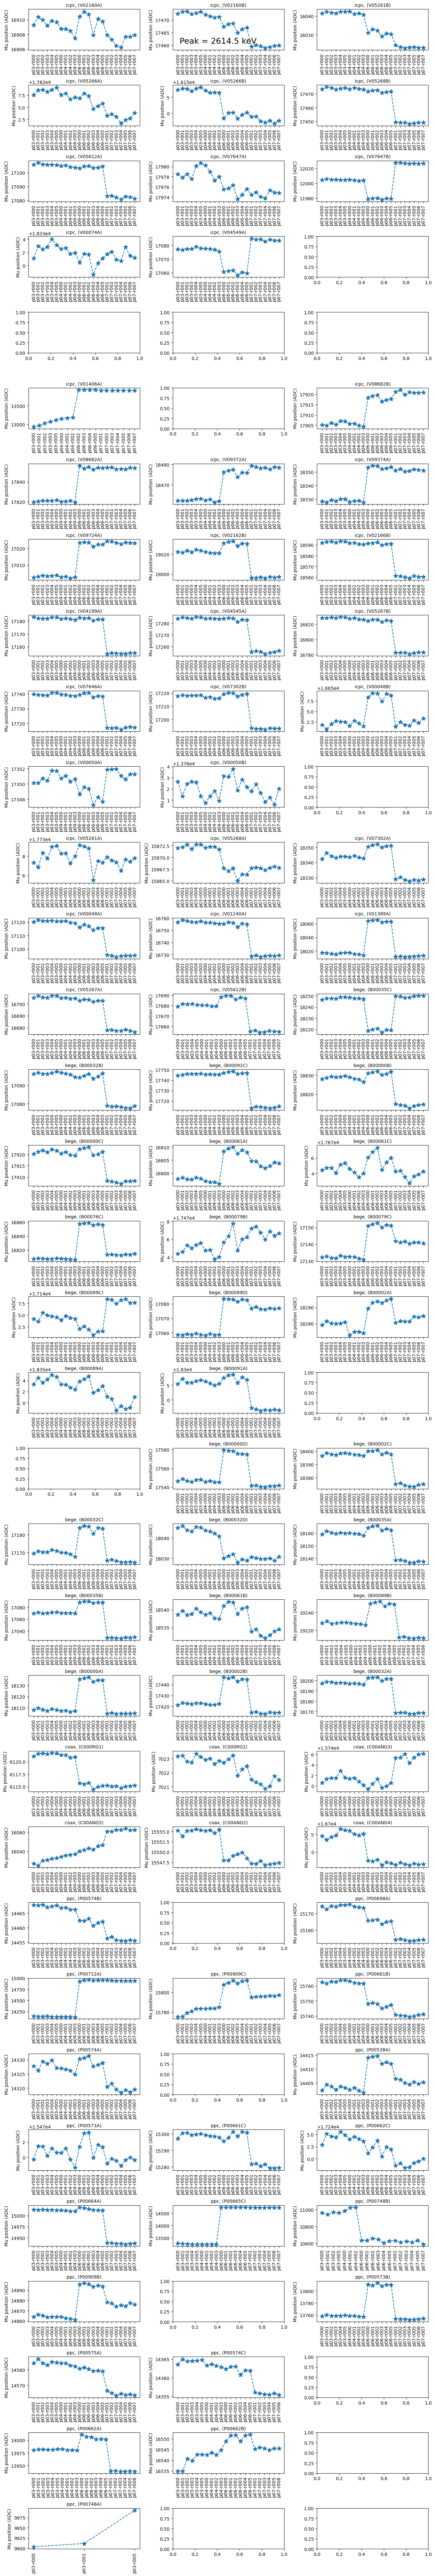


-------------------------------------------------------------------------------------------------



In [15]:
for peak in [all_fitted_peaks[0], all_fitted_peaks[5], all_fitted_peaks[6]][2:]:
    fig, axs = plt.subplots(int(np.ceil(len(all_params_ch)/3)), 3, figsize=(13.5, 80))
    for i, (ax, channel) in enumerate(zip(axs.flatten(), all_params_ch.keys())):
        det_type = channel_dict[int(channel[2:])][0]
        det_name = channel_dict[int(channel[2:])][1]
        try:
            ax.errorbar(list(all_params_ch[channel]['mus_peaks'][peak].keys()), 
                        list(all_params_ch[channel]['mus_peaks'][peak].values()),
                        yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()), 
                        marker='*', linestyle='--', markersize=10, label=channel)
            ax.tick_params(axis='x', labelsize=10, rotation=90)
            ax.tick_params(axis='y', labelsize=10)
            ax.set_title(f'{det_type}, ({det_name})', fontsize=10)
            ax.set_ylabel('Mu position (ADC)', fontsize=10)
        except KeyError:
            #print(channel, peak)
            continue
    fig.suptitle(f'Peak = {peak} keV', fontsize=18)
    plt.tight_layout()
    plt.show()
    print()
    print('-------------------------------------------------------------------------------------------------')
    print()

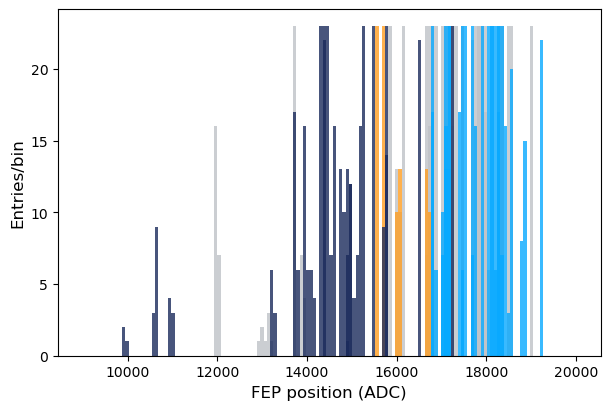

In [16]:
for peak in [all_fitted_peaks[6]]:
    fig = plt.figure(figsize=(7, 4.5))
    for i, (ax, channel) in enumerate(zip(axs.flatten(), all_params_ch.keys())):
        det_type = channel_dict[int(channel[2:])][0]
        try:
            if   det_type=='icpc': col = '#BFC2C7'
            elif det_type=='bege': col = '#07A9FF'
            elif det_type=='coax': col = '#FF9E21'
            elif det_type=='ppc':  col = '#1A2A5B'
            plt.hist(list(all_params_ch[channel]['mus_peaks'][peak].values()), bins=150, range=(9000, 20000),
                     label=channel, alpha=0.8, color=col)
        except KeyError:
            continue
            
    plt.xlabel('FEP position (ADC)', fontsize=12)
    plt.ylabel('Entries/bin',        fontsize=12)
    plt.show()

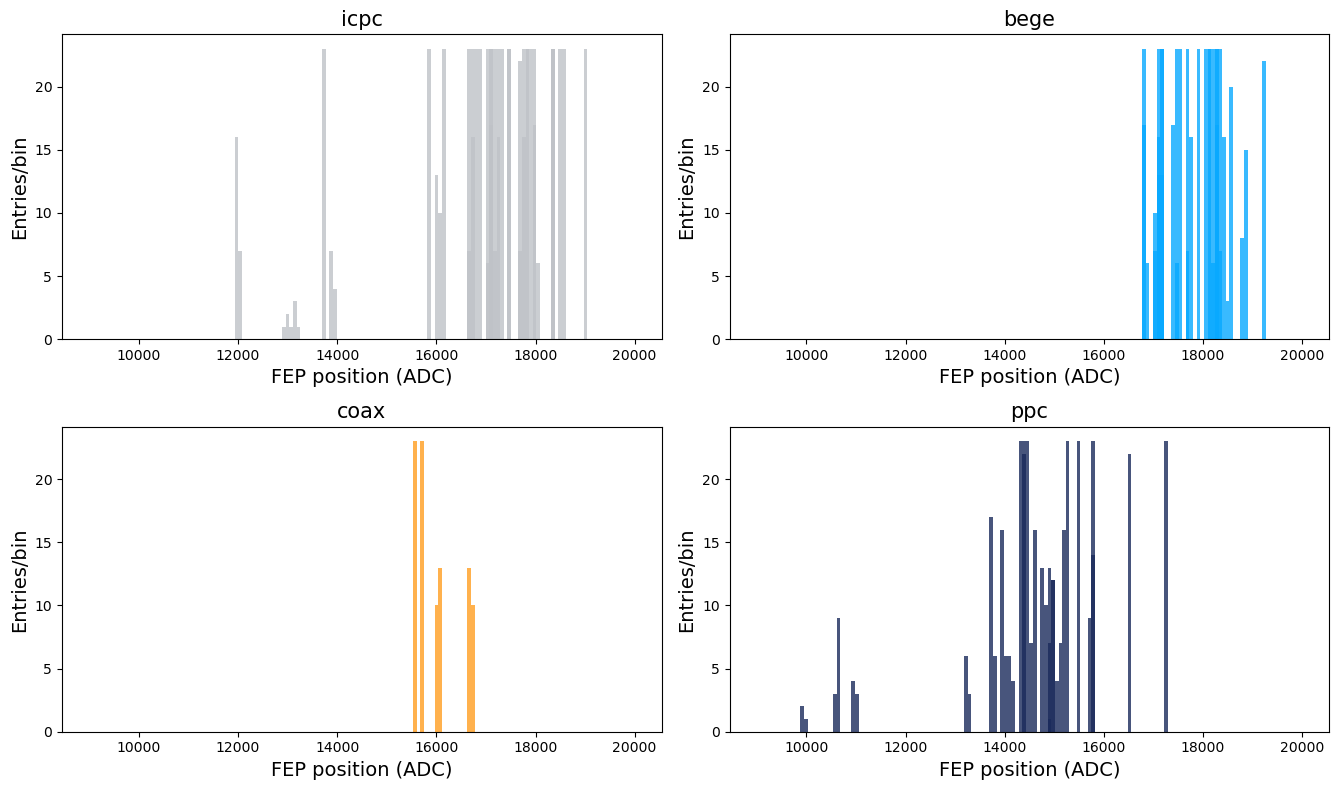

In [17]:
for peak in [all_fitted_peaks[6]]:
    fig, axs = plt.subplots(2, 2, figsize=(13.5, 8))
    for ax, d_type, col in zip(axs.flatten(), ['icpc', 'bege', 'coax', 'ppc'], ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B']):
        for channel in all_params_ch.keys():
            det_type = channel_dict[int(channel[2:])][0]
            try:
                if det_type==d_type:
                    ax.hist(list(all_params_ch[channel]['mus_peaks'][peak].values()), bins=150, range=(9000, 20000),
                            label=channel, alpha=0.8, color=col)
            except KeyError:
                continue
                
        ax.set_xlabel('FEP position (ADC)', fontsize=14)
        ax.set_ylabel('Entries/bin',        fontsize=14)
        ax.set_title(d_type,                fontsize=15)
plt.tight_layout()
plt.show()

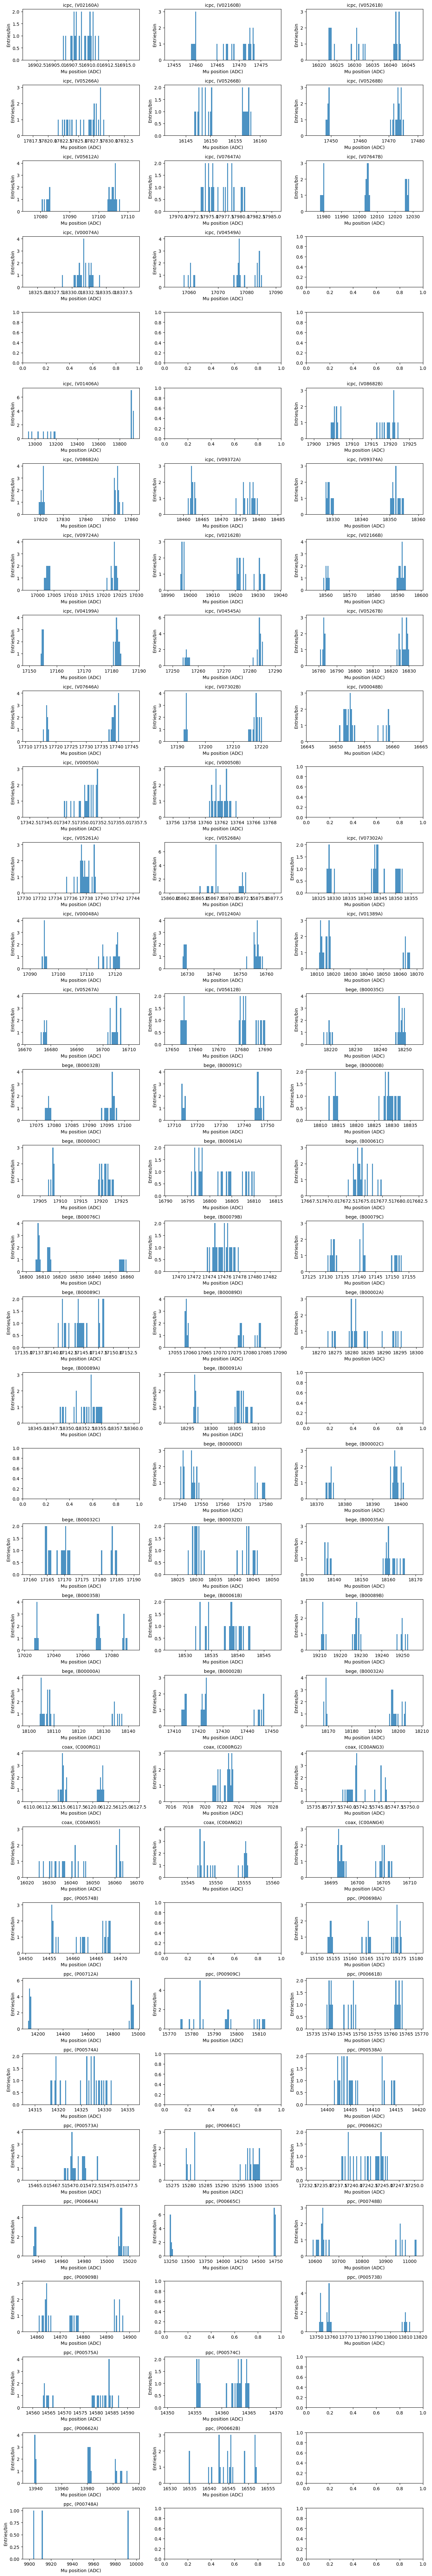


-------------------------------------------------------------------------------------------------



In [18]:
for peak in [all_fitted_peaks[6]]:
    fig, axs = plt.subplots(int(np.ceil(len(all_params_ch)/3)), 3, figsize=(13.5, 80))
    for i, (ax, channel) in enumerate(zip(axs.flatten(), all_params_ch.keys())):
        det_type = channel_dict[int(channel[2:])][0]
        det_name = channel_dict[int(channel[2:])][1]
        try:
            ax.hist(list(all_params_ch[channel]['mus_peaks'][peak].values()), bins=100, label=channel, alpha=0.8,
                   range=(min(list(all_params_ch[channel]['mus_peaks'][peak].values()))-5,
                          max(list(all_params_ch[channel]['mus_peaks'][peak].values()))+5))
            ax.set_title(f'{det_type}, ({det_name})', fontsize=10)
            ax.set_xlabel('Mu position (ADC)', fontsize=10)
            ax.set_ylabel('Entries/bin', fontsize=10)
        except KeyError:
            #print(channel, peak)
            continue
    plt.tight_layout()
    plt.show()
    print()
    print('-------------------------------------------------------------------------------------------------')
    print()

### Mu position

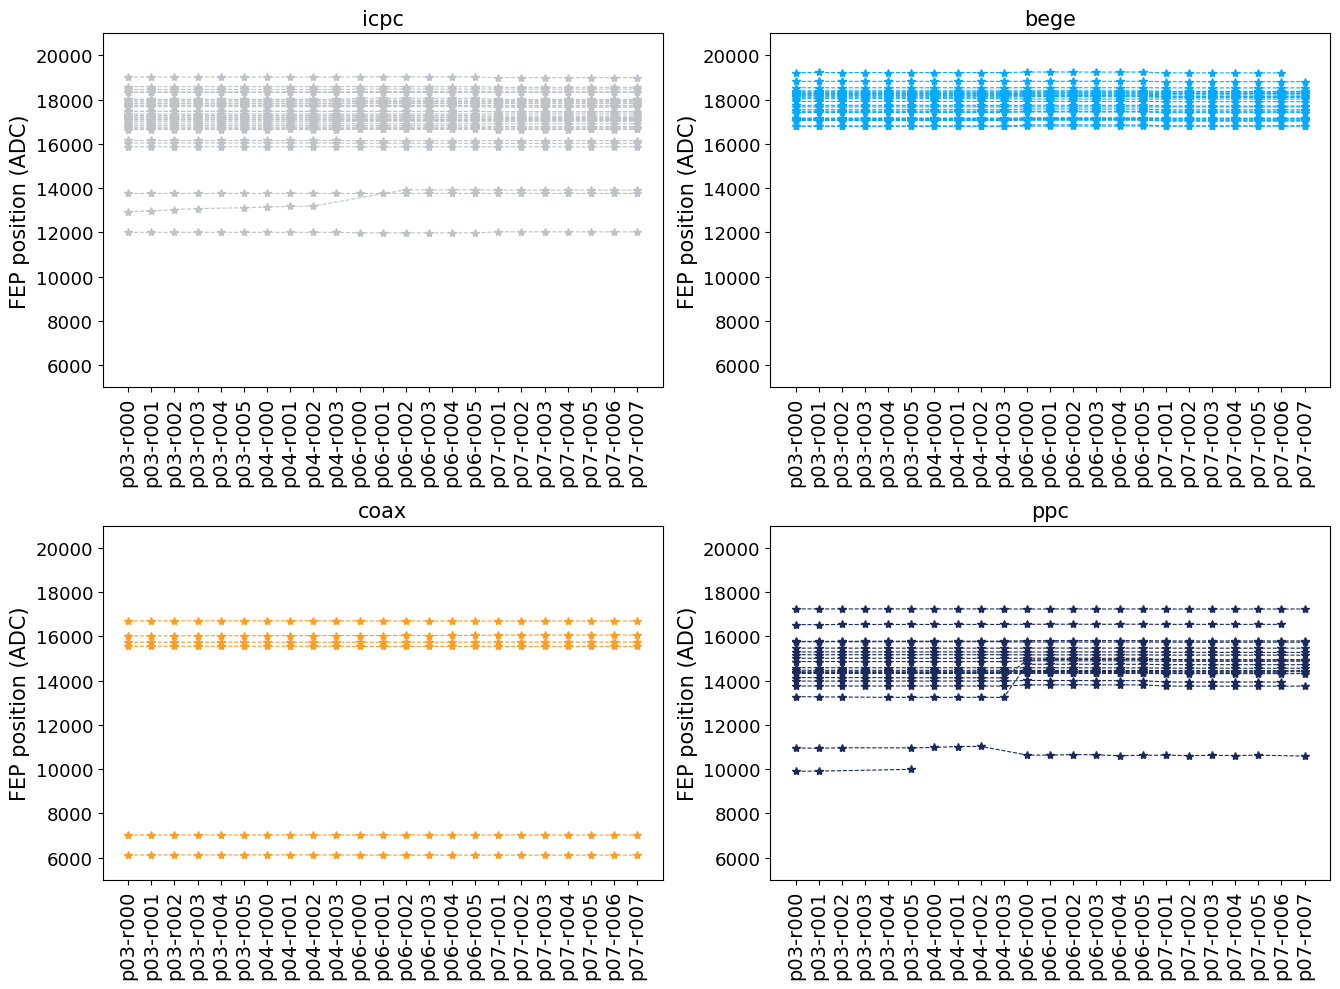

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(13.5, 10))
for ax, d_type, col in zip(axs.flatten(), ['icpc', 'bege', 'coax', 'ppc'], ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B']):
    for channel in list(all_params_ch.keys()):
        det_type = channel_dict[int(channel[2:])][0]
        if d_type==det_type:
            try:
                ax.errorbar(list(all_params_ch[channel]['mus_peaks'][peak].keys()), 
                            list(all_params_ch[channel]['mus_peaks'][peak].values()),
                            yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()), 
                            marker='*', linestyle='--', markersize=6, label=channel, color=col, linewidth=0.8)
                ax.tick_params(axis='x', labelsize=14, rotation=90)
                ax.tick_params(axis='y', labelsize=13)
                ax.set_title(f'{d_type}', fontsize=15)
                ax.set_ylabel('FEP position (ADC)', fontsize=15)
                ax.set_ylim(5000, 21000)
            except KeyError:
                continue
plt.tight_layout()
plt.show()

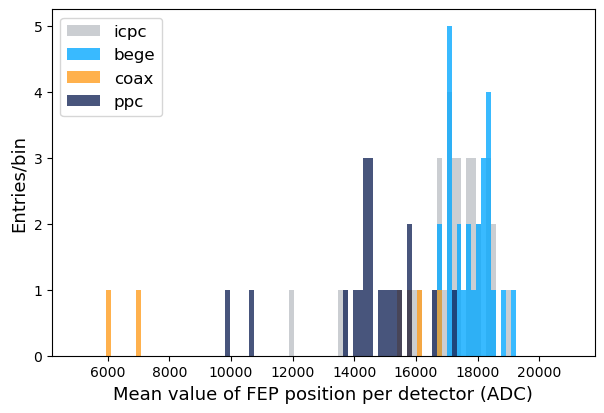

In [20]:
fig = plt.figure(figsize=(7, 4.5))
for ax, d_type, col in zip(axs.flatten(), ['icpc', 'bege', 'coax', 'ppc'], ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B']):
    mu_FEP = []
    for channel in list(all_params_ch.keys()):
        det_type = channel_dict[int(channel[2:])][0]
        if d_type==det_type:
            try:
                mu_FEP.append(np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values())))
            except KeyError:
                continue
                
    plt.hist(mu_FEP, bins=100, range=(5000, 21000), color=col, alpha=0.8, label=d_type)
plt.xlabel('Mean value of FEP position per detector (ADC)', fontsize=13)
plt.ylabel('Entries/bin',                                   fontsize=13)
plt.legend(fontsize=12)
plt.show()

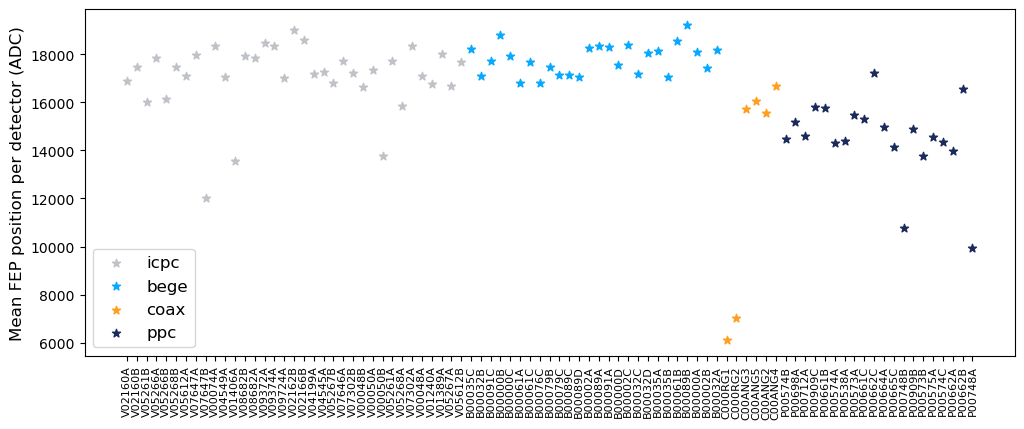

In [21]:
fig = plt.figure(figsize=(12, 4.5))
for ax, d_type, col in zip(axs.flatten(), ['icpc', 'bege', 'coax', 'ppc'], ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B']):
    mu_FEP   = []
    ch_names = []
    for channel in list(all_params_ch.keys()):
        det_type = channel_dict[int(channel[2:])][0]
        det_name = channel_dict[int(channel[2:])][1]
        if d_type==det_type:
            try:
                mu_FEP  .append(np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values())))
                ch_names.append(det_name)
            except KeyError:
                continue
                
    plt.scatter(ch_names, mu_FEP, marker='*', color=col, label=d_type)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Mean FEP position per detector (ADC)', fontsize=12)
plt.legend(fontsize=12, loc=0)
plt.show()

ch1115203 V01406A icpc
ch1112001 P00712A ppc
ch1081603 P00665C ppc
ch1081604 P00748B ppc


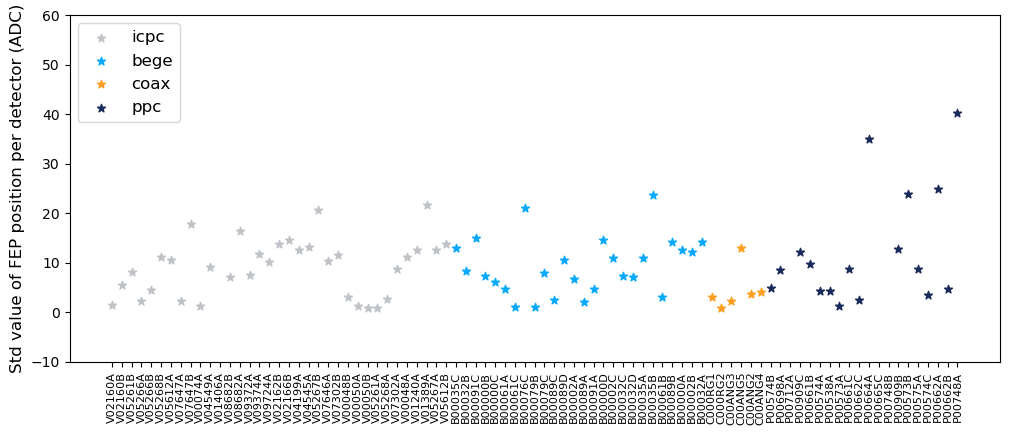

In [22]:
fig = plt.figure(figsize=(12, 4.5))
for ax, d_type, col in zip(axs.flatten(), ['icpc', 'bege', 'coax', 'ppc'], ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B']):
    std_FEP  = []
    ch_names = []
    for channel in list(all_params_ch.keys()):
        det_type = channel_dict[int(channel[2:])][0]
        det_name = channel_dict[int(channel[2:])][1]
        if d_type==det_type:
            try:
                std_FEP .append(np.std(list(all_params_ch[channel]['mus_peaks'][peak].values())))
                ch_names.append(det_name)
                if np.std(list(all_params_ch[channel]['mus_peaks'][peak].values())) > 100:
                    print(channel, det_name, det_type)
            except KeyError:
                continue
                
    plt.scatter(ch_names, std_FEP, marker='*', color=col, label=d_type)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Std value of FEP position per detector (ADC)', fontsize=12)
plt.legend(fontsize=12, loc=2)
#plt.yscale('log')
plt.ylim(-10, 60)
plt.show()

### Energy resolution in Qbb in keV (FWHM)

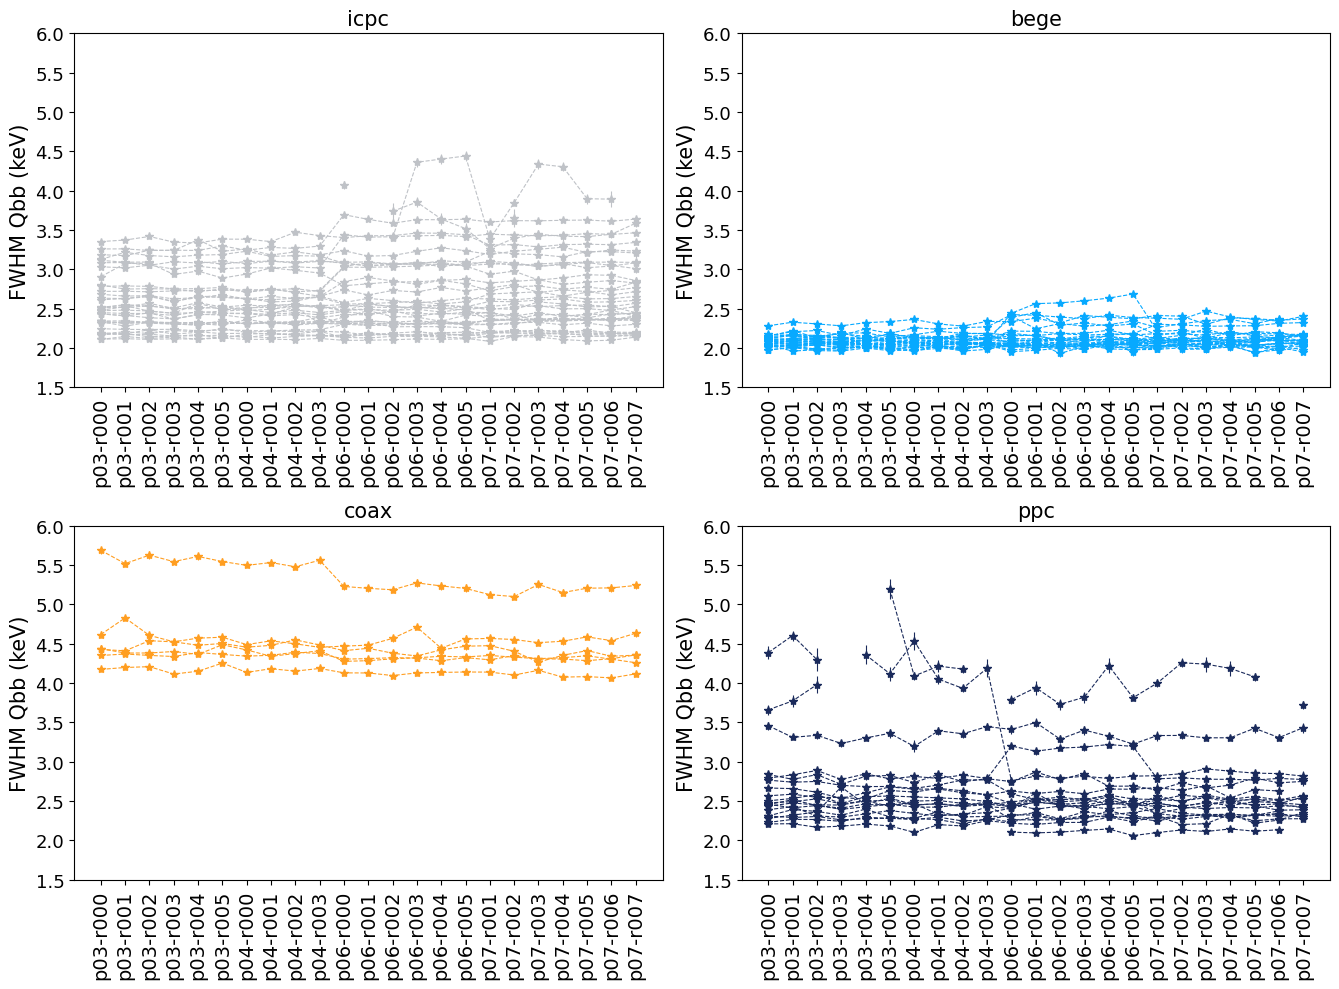

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(13.5, 10))
for ax, d_type, col in zip(axs.flatten(), ['icpc', 'bege', 'coax', 'ppc'], ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B']):
    for channel in list(all_params_ch.keys()):
        det_type = channel_dict[int(channel[2:])][0]
        if d_type==det_type:
            Qbb_fwhm_ch     = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
            Qbb_fwhm_ch_err = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_err_in_keV']])
            Qbb_fwhm_keys   = np.array([list(el.keys  ())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
            ax.errorbar(Qbb_fwhm_keys, Qbb_fwhm_ch, yerr=Qbb_fwhm_ch_err,
                     marker='*', linestyle='--', markersize=6, label=channel, color=col, linewidth=0.8)
            
            ax.tick_params(axis='x', labelsize=14, rotation=90)
            ax.tick_params(axis='y', labelsize=13)
            ax.set_title(f'{d_type}', fontsize=15)
            ax.set_ylabel('FWHM Qbb (keV)', fontsize=15)
            ax.set_ylim(1.5, 6)
plt.tight_layout()
plt.show()

### Sigma Qbb in ADC

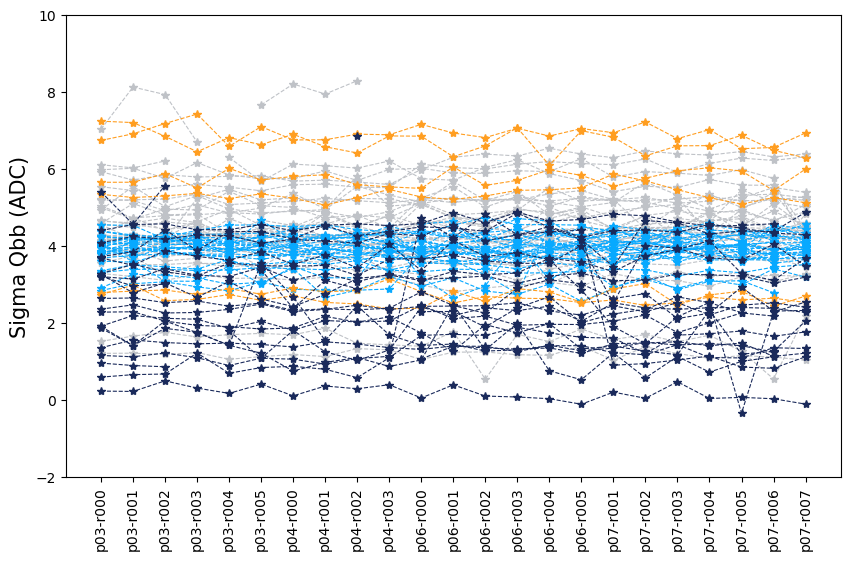

In [24]:
fig = plt.figure(figsize=(10, 6))
for channel in list(all_params_ch.keys()):
    det_type = channel_dict[int(channel[2:])][0]
    if   det_type=='icpc': col = '#BFC2C7'
    elif det_type=='bege': col = '#07A9FF'
    elif det_type=='coax': col = '#FF9E21'
    elif det_type=='ppc':  col = '#1A2A5B'
    Qbb_fwhm_uncal = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])
    Qbb_sig_uncal  = Qbb_fwhm_uncal/2.355
    plt.errorbar([list(i.keys())[0] for i in all_params_ch[channel]['Qbb_fwhms_in_ADC']], Qbb_sig_uncal,
                 marker='*', linestyle='--', markersize=6, label=channel, color=col, linewidth=0.8)
plt.xticks(rotation=90)
plt.ylabel('Sigma Qbb (ADC)', fontsize=15)
plt.ylim(-2, 10)
plt.show()

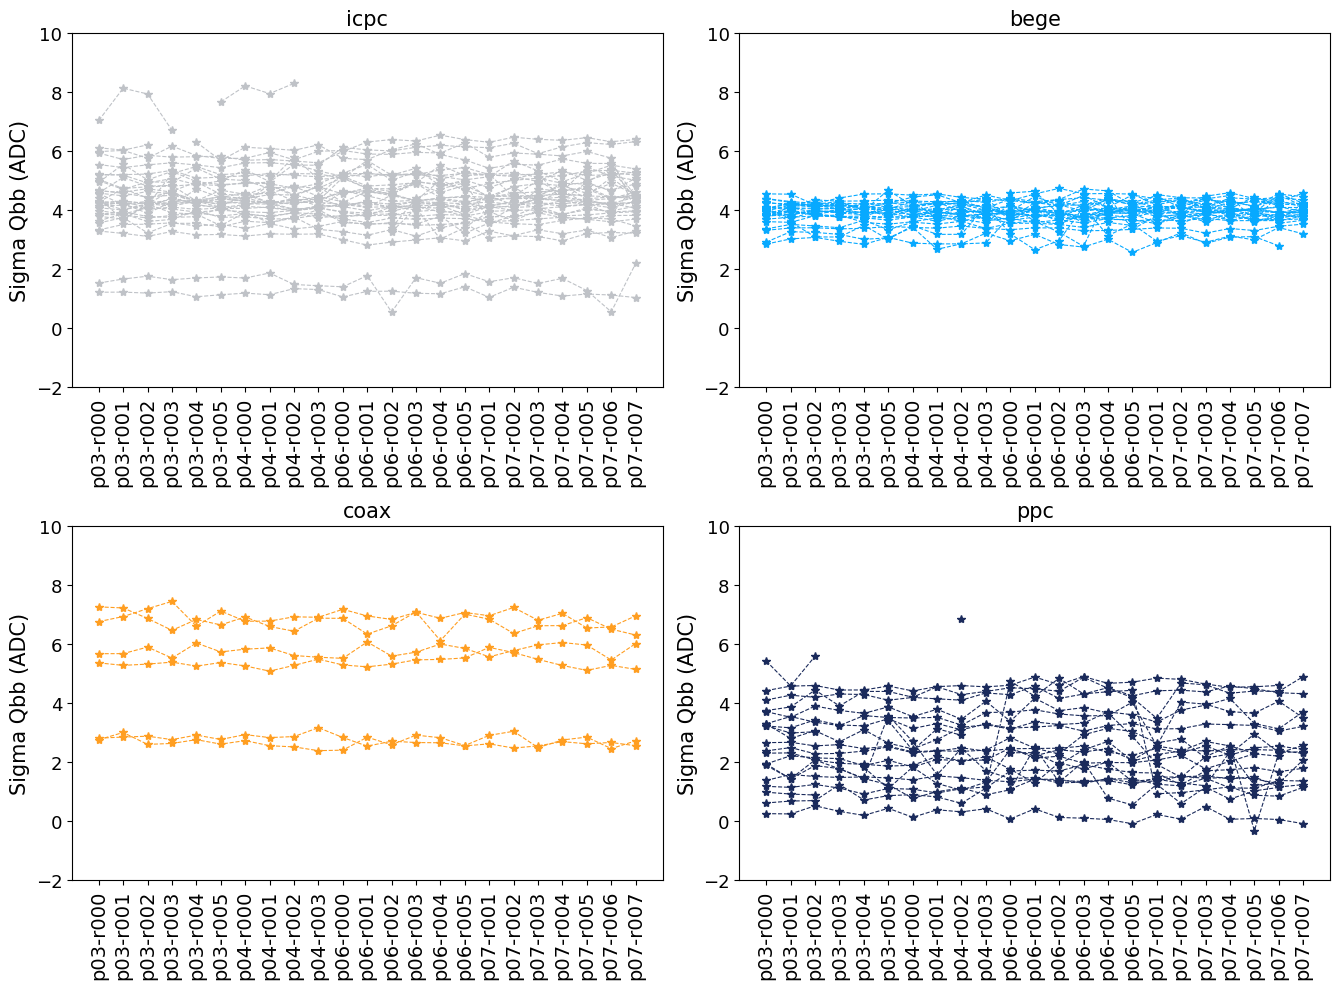

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(13.5, 10))
for ax, d_type, col in zip(axs.flatten(), ['icpc', 'bege', 'coax', 'ppc'], ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B']):
    for channel in list(all_params_ch.keys()):
        det_type = channel_dict[int(channel[2:])][0]
        if d_type==det_type:
            Qbb_fwhm_uncal = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])
            Qbb_sig_uncal  = Qbb_fwhm_uncal/2.355
            ax.errorbar([list(i.keys())[0] for i in all_params_ch[channel]['Qbb_fwhms_in_ADC']], Qbb_sig_uncal,
                     marker='*', linestyle='--', markersize=6, label=channel, color=col, linewidth=0.8)
            
            ax.tick_params(axis='x', labelsize=14, rotation=90)
            ax.tick_params(axis='y', labelsize=13)
            ax.set_title(f'{d_type}', fontsize=15)
            ax.set_ylabel('Sigma Qbb (ADC)', fontsize=15)
            ax.set_ylim(-2, 10)
plt.tight_layout()
plt.show()

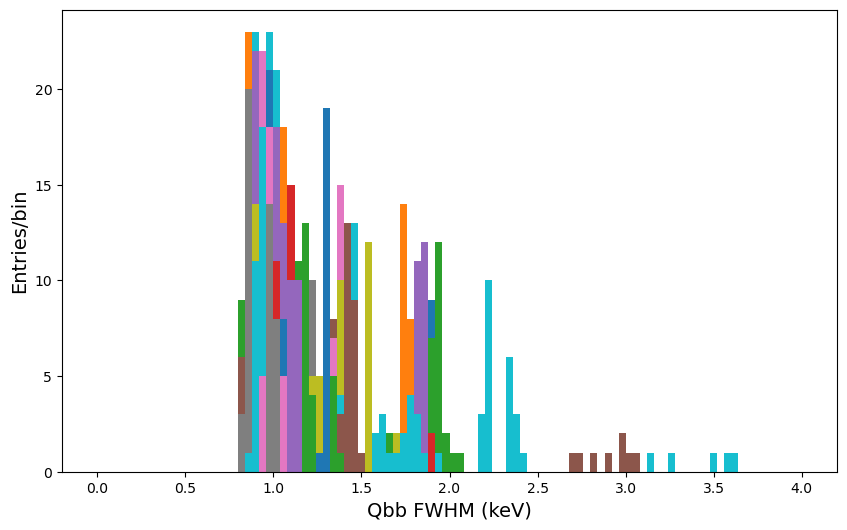

In [26]:
fig = plt.figure(figsize=(10, 6))
for channel in all_params_ch.keys():
    Qbb_fwhm_ch   = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
    Qbb_fwhm_keys = np.array([list(el.keys  ())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
    plt.hist(Qbb_fwhm_ch/2.355, bins=100, range=(0, 4), label=channel+f', $\sigma$ = {np.round(np.mean(Qbb_fwhm_ch/2.355), decimals=2)} keV')
plt.xlabel('Qbb FWHM (keV)', fontsize=14)
plt.ylabel('Entries/bin', fontsize=14)
plt.show()

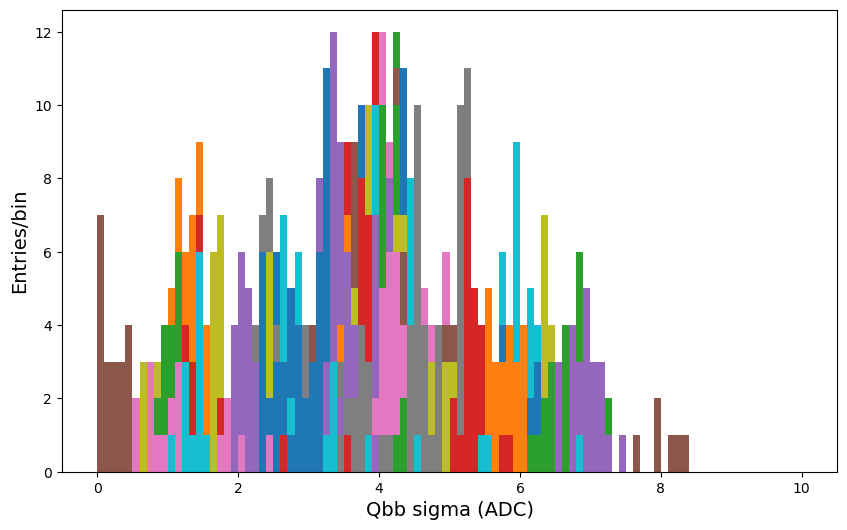

In [27]:
fig = plt.figure(figsize=(10, 6))
for channel in all_params_ch.keys():
    Qbb_fwhm_uncal = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])
    Qbb_sig_uncal  = Qbb_fwhm_uncal/2.355
    plt.hist(Qbb_sig_uncal, bins=100, range=(0, 10), label=channel)
plt.xlabel('Qbb sigma (ADC)', fontsize=14)
plt.ylabel('Entries/bin', fontsize=14)
#plt.legend(fontsize=12)
plt.show()

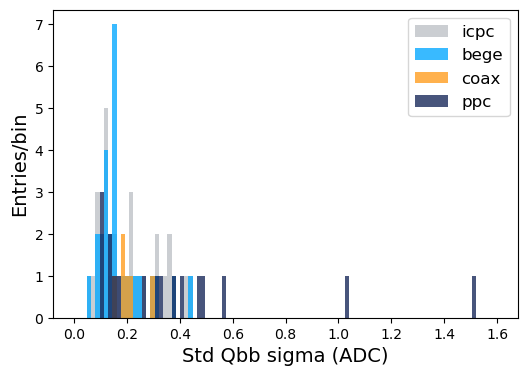

In [28]:
fig = plt.figure(figsize=(6, 4))
for ax, d_type, col in zip(axs.flatten(), ['icpc', 'bege', 'coax', 'ppc'], ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B']):
    std_sigma_Qbb = []
    for channel in list(all_params_ch.keys()):
        det_type = channel_dict[int(channel[2:])][0]
        if d_type==det_type:
            try:
                Qbb_fwhm_uncal = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])
                Qbb_sig_uncal  = Qbb_fwhm_uncal/2.355
                std_sigma_Qbb.append(np.std(Qbb_sig_uncal))
            except KeyError:
                continue
    plt.hist(std_sigma_Qbb, bins=100, range=(0, 1.6), color=col, alpha=0.8, label=d_type)
plt.xlabel('Std Qbb sigma (ADC)', fontsize=14)
plt.ylabel('Entries/bin', fontsize=14)
plt.legend(fontsize=12)
plt.show()

### Associate Sigma E res Qbb with std of mu FEP per channel

In [29]:
problematic_ch_name = ['V07647B', 'V01406A', 'V02162B', 'V00050A', 'V00050B', 'V07302A', #ICPC
                       'B00061A', 'B00089C', 'B00089A', 'B00000D', 'B00000A', 'B00089B', #BeGe
                       'C00ANG5',                                                        #Coax
                       'P00574B', 'P00698A', 'P00712A', 'P00574A', 'P00573A', 'P00665C', #PPC
                       'P00748B', 'P00909B', 'P00573B', 'P00575A', 'P00574C', 'P00662A', 'P00662B', 'P00748A']

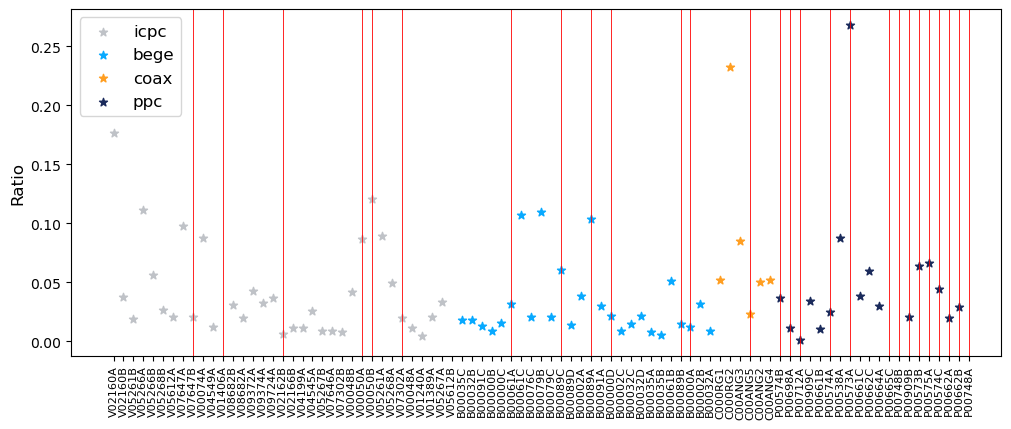

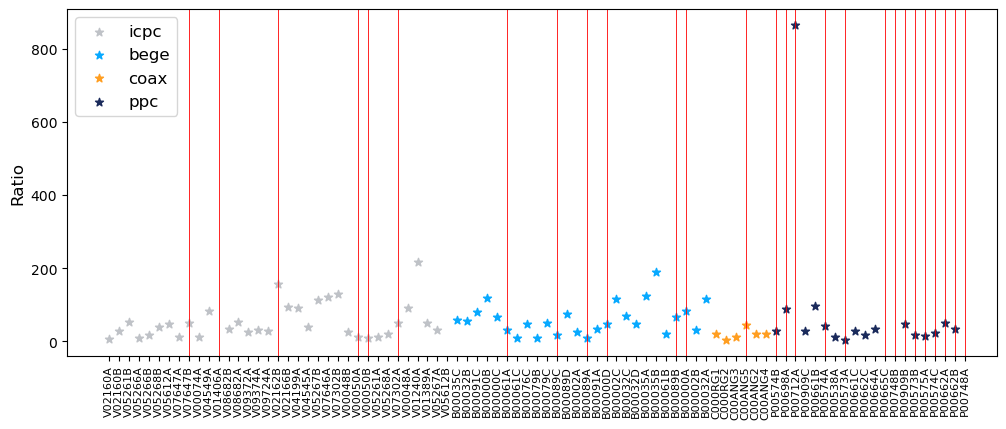

In [31]:
fig = plt.figure(figsize=(12, 4.5))
for ax, d_type, col in zip(axs.flatten(), ['icpc', 'bege', 'coax', 'ppc'], ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B']):
    std_FEP  = []
    std_Qbb  = []
    ch_names = []
    for channel in list(all_params_ch.keys()):
        det_type = channel_dict[int(channel[2:])][0]
        det_name = channel_dict[int(channel[2:])][1]
        if d_type==det_type:
            try:
                Qbb_fwhm_uncal = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])
                Qbb_sig_uncal  = Qbb_fwhm_uncal/2.355
                std_FEP .append(np.std(list(all_params_ch[channel]['mus_peaks'][peak].values())))
                std_Qbb .append(np.std(Qbb_sig_uncal))
                ch_names.append(det_name)
            except KeyError:
                #plt.axvline(x=det_name, color='purple', linewidth=0.6)
                continue
    
    std_FEP = np.array(std_FEP)
    std_Qbb = np.array(std_Qbb)
    plt.scatter(ch_names, std_Qbb/std_FEP, marker='*', color=col, label=d_type)
for ch in problematic_ch_name:
    plt.axvline(x=ch, color='r', linewidth=0.6)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Ratio', fontsize=12)
plt.legend(fontsize=12, loc=2)
#plt.yscale('log')
#plt.ylim(-10, 60)
plt.show()

fig = plt.figure(figsize=(12, 4.5))
for ax, d_type, col in zip(axs.flatten(), ['icpc', 'bege', 'coax', 'ppc'], ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B']):
    std_FEP  = []
    std_Qbb  = []
    ch_names = []
    for channel in list(all_params_ch.keys()):
        det_type = channel_dict[int(channel[2:])][0]
        det_name = channel_dict[int(channel[2:])][1]
        if d_type==det_type:
            try:
                Qbb_fwhm_uncal = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])
                Qbb_sig_uncal  = Qbb_fwhm_uncal/2.355
                std_FEP .append(np.std(list(all_params_ch[channel]['mus_peaks'][peak].values())))
                std_Qbb .append(np.std(Qbb_sig_uncal))
                ch_names.append(det_name)
            except KeyError:
                #plt.axvline(x=det_name, color='purple', linewidth=0.6)
                continue
    
    std_FEP = np.array(std_FEP)
    std_Qbb = np.array(std_Qbb)
    plt.scatter(ch_names, std_FEP/std_Qbb, marker='*', color=col, label=d_type)
for ch in problematic_ch_name:
    plt.axvline(x=ch, color='r', linewidth=0.6)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Ratio', fontsize=12)
plt.legend(fontsize=12, loc=2)
#plt.yscale('log')
#plt.ylim(-10, 60)
plt.show()

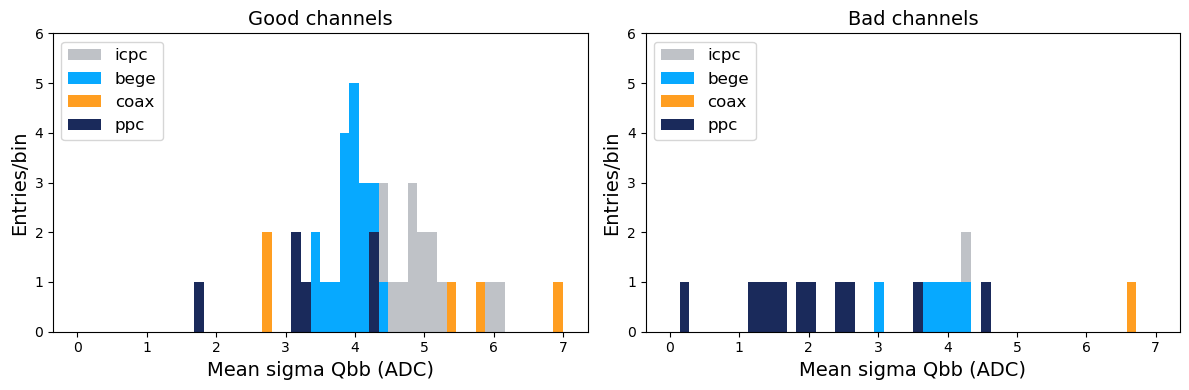

In [32]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
for d_type, col in zip(['icpc', 'bege', 'coax', 'ppc'], ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B']):
    mean_sigma_Qbb_good = []
    mean_sigma_Qbb_bad  = []
    for channel in list(all_params_ch.keys()):
        det_type = channel_dict[int(channel[2:])][0]
        det_name = channel_dict[int(channel[2:])][1]
        if d_type==det_type:
            try:
                Qbb_fwhm_uncal = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])
                Qbb_sig_uncal  = Qbb_fwhm_uncal/2.355
                if det_name in problematic_ch_name:
                    mean_sigma_Qbb_bad .append(np.mean(Qbb_sig_uncal))
                else:
                    mean_sigma_Qbb_good.append(np.mean(Qbb_sig_uncal))
            except KeyError:
                #plt.axvline(x=det_name, color='purple', linewidth=0.6)
                continue
    
    mean_sigma_Qbb_good = np.array(mean_sigma_Qbb_good)
    mean_sigma_Qbb_bad  = np.array(mean_sigma_Qbb_bad )
    ax0.hist(mean_sigma_Qbb_good, bins=50, range=(0, 7), color=col, label=d_type)
    ax1.hist(mean_sigma_Qbb_bad,  bins=50, range=(0, 7), color=col, label=d_type)
    ax0.set_xlabel('Mean sigma Qbb (ADC)', fontsize=14)
    ax1.set_xlabel('Mean sigma Qbb (ADC)', fontsize=14)
    ax0.set_ylabel('Entries/bin', fontsize=14)
    ax1.set_ylabel('Entries/bin', fontsize=14)
    ax0.set_title('Good channels', fontsize=14)
    ax1.set_title('Bad channels', fontsize=14)
    ax0.legend(fontsize=12, loc=2)
    ax1.legend(fontsize=12, loc=2)
    ax0.set_ylim(0, 6)
    ax1.set_ylim(0, 6)
plt.tight_layout()
plt.show()

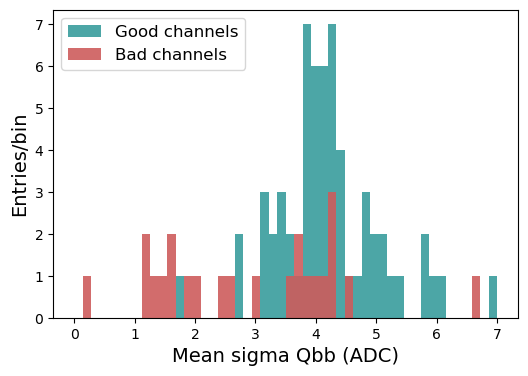

In [33]:
fig = plt.figure(figsize=(6, 4))
mean_sigma_Qbb_good = []
mean_sigma_Qbb_bad  = []
for channel in list(all_params_ch.keys()):
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    try:
        Qbb_fwhm_uncal = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])
        Qbb_sig_uncal  = Qbb_fwhm_uncal/2.355
        if det_name in problematic_ch_name:
            mean_sigma_Qbb_bad .append(np.mean(Qbb_sig_uncal))
        else:
            mean_sigma_Qbb_good.append(np.mean(Qbb_sig_uncal))
    except KeyError:
        continue

mean_sigma_Qbb_good = np.array(mean_sigma_Qbb_good)
mean_sigma_Qbb_bad  = np.array(mean_sigma_Qbb_bad )
plt.hist(mean_sigma_Qbb_good, bins=50, range=(0, 7), color='teal',      label='Good channels', alpha=0.7)
plt.hist(mean_sigma_Qbb_bad,  bins=50, range=(0, 7), color='indianred', label='Bad channels',  alpha=0.9)
plt.xlabel('Mean sigma Qbb (ADC)', fontsize=14)
plt.ylabel('Entries/bin',          fontsize=14)
plt.legend(fontsize=12, loc=2)
plt.show()

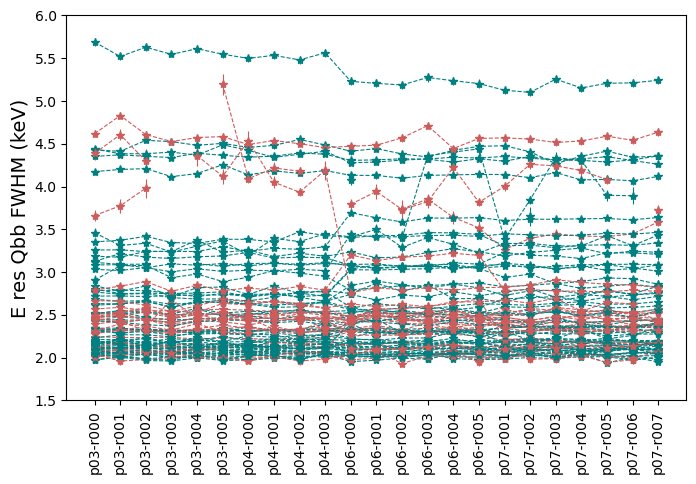

In [34]:
fig = plt.figure(figsize=(8, 5))
for channel in list(all_params_ch.keys()):
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    try:
        Qbb_fwhm_ch     = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
        Qbb_fwhm_ch_err = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_err_in_keV']])
        Qbb_fwhm_keys   = np.array([list(el.keys  ())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
            
        if det_name in problematic_ch_name:
            plt.errorbar(Qbb_fwhm_keys, Qbb_fwhm_ch, yerr=Qbb_fwhm_ch_err,
                         marker='*', linestyle='--', markersize=6, label=channel, color='indianred', linewidth=0.8)
        else:
            plt.errorbar(Qbb_fwhm_keys, Qbb_fwhm_ch, yerr=Qbb_fwhm_ch_err,
                         marker='*', linestyle='--', markersize=6, label=channel, color='teal', linewidth=0.8)
    except KeyError:
        continue

plt.ylabel('E res Qbb FWHM (keV)', fontsize=14)
plt.xticks(rotation=90)
plt.ylim(1.5, 6)
plt.show()

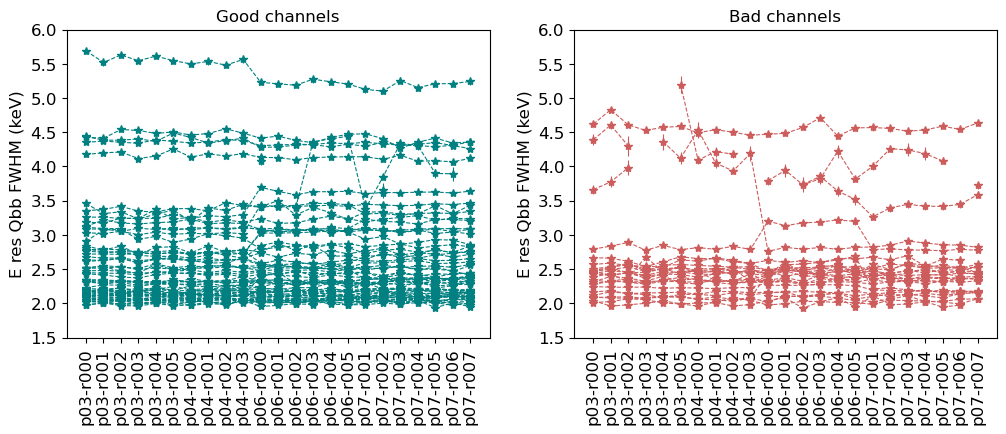

In [35]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
for channel in list(all_params_ch.keys()):
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    try:
        Qbb_fwhm_ch     = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
        Qbb_fwhm_ch_err = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_err_in_keV']])
        Qbb_fwhm_keys   = np.array([list(el.keys  ())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
            
        if det_name in problematic_ch_name:
            ax1.errorbar(Qbb_fwhm_keys, Qbb_fwhm_ch, yerr=Qbb_fwhm_ch_err,
                         marker='*', linestyle='--', markersize=6, label=channel, color='indianred', linewidth=0.8)
        else:
            ax0.errorbar(Qbb_fwhm_keys, Qbb_fwhm_ch, yerr=Qbb_fwhm_ch_err,
                         marker='*', linestyle='--', markersize=6, label=channel, color='teal', linewidth=0.8)
    except KeyError:
        continue

ax0.tick_params(axis='x', labelsize=12, rotation=90)
ax0.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='x', labelsize=12, rotation=90)
ax1.tick_params(axis='y', labelsize=12)
ax0.set_ylabel('E res Qbb FWHM (keV)', fontsize=12)
ax1.set_ylabel('E res Qbb FWHM (keV)', fontsize=12)
ax0.set_title('Good channels')
ax1.set_title('Bad channels')
ax0.set_ylim(1.5, 6)
ax1.set_ylim(1.5, 6)
plt.show()

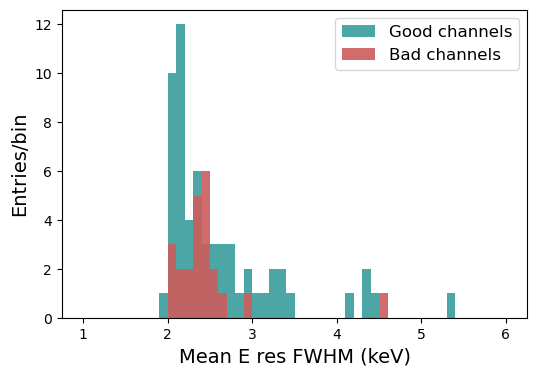

In [36]:
fig = plt.figure(figsize=(6, 4))
e_res_good_channels = []
e_res_bad_channels  = []
for channel in list(all_params_ch.keys()):
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    try:
        Qbb_fwhm_ch = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
        if det_name in problematic_ch_name:
            e_res_bad_channels.append(np.mean(Qbb_fwhm_ch))
        else:
            e_res_good_channels.append(np.mean(Qbb_fwhm_ch))
    except KeyError:
        continue

e_res_good_channels = np.array(e_res_good_channels)
e_res_bad_channels  = np.array(e_res_bad_channels )
plt.hist(e_res_good_channels, bins=50, range=(1, 6), color='teal',      label='Good channels', alpha=0.7)
plt.hist(e_res_bad_channels,  bins=50, range=(1, 6), color='indianred', label='Bad channels',  alpha=0.9)
plt.xlabel('Mean E res FWHM (keV)', fontsize=14)
plt.ylabel('Entries/bin',          fontsize=14)
plt.legend(fontsize=12)
plt.show()

## Gain

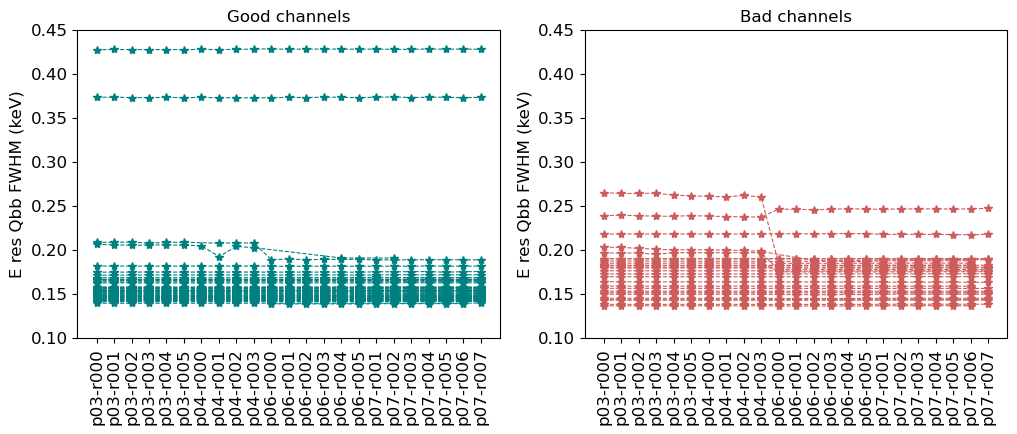

In [37]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
for channel in list(all_params_ch.keys()):
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    try:
        gain_ch   = np.array([list(el.values())[0] for el in all_params_ch[channel]['gains']])
        gain_ch_k = np.array([list(el.keys())  [0] for el in all_params_ch[channel]['gains']])
            
        if det_name in problematic_ch_name:
            ax1.errorbar(gain_ch_k, gain_ch,
                         marker='*', linestyle='--', markersize=6, label=channel, color='indianred', linewidth=0.8)
        else:
            ax0.errorbar(gain_ch_k, gain_ch,
                         marker='*', linestyle='--', markersize=6, label=channel, color='teal', linewidth=0.8)
    except KeyError:
        continue

ax0.tick_params(axis='x', labelsize=12, rotation=90)
ax0.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='x', labelsize=12, rotation=90)
ax1.tick_params(axis='y', labelsize=12)
ax0.set_ylabel('E res Qbb FWHM (keV)', fontsize=12)
ax1.set_ylabel('E res Qbb FWHM (keV)', fontsize=12)
ax0.set_title('Good channels')
ax1.set_title('Bad channels')
ax0.set_ylim(0.1, 0.45)
ax1.set_ylim(0.1, 0.45)
plt.show()

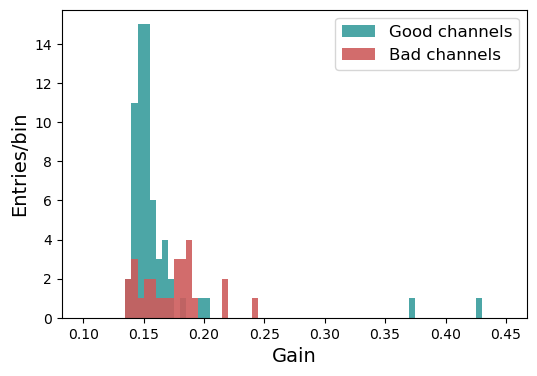

In [38]:
fig = plt.figure(figsize=(6, 4))
gain_good_channels = []
gain_bad_channels  = []
for channel in list(all_params_ch.keys()):
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    try:
        gain_ch = np.array([list(el.values())[0] for el in all_params_ch[channel]['gains']])
        if det_name in problematic_ch_name:
            gain_bad_channels.append(np.mean(gain_ch))
        else:
            gain_good_channels.append(np.mean(gain_ch))
    except KeyError:
        continue

gain_good_channels = np.array(gain_good_channels)
gain_bad_channels  = np.array(gain_bad_channels )
plt.hist(gain_good_channels, bins=70, range=(0.1, 0.45), color='teal',      label='Good channels', alpha=0.7)
plt.hist(gain_bad_channels , bins=70, range=(0.1, 0.45), color='indianred', label='Bad channels',  alpha=0.9)
plt.xlabel('Gain',        fontsize=14)
plt.ylabel('Entries/bin', fontsize=14)
plt.legend(fontsize=12)
plt.show()

## Partitions

In [39]:
def compute_and_plot_partition(channel, peak, col='teal', ylim=''):
    mus    = list(all_params_ch[channel]['mus_peaks'][peak].values())
    sigmas = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])/2.355
    
    partition_change = [0]
    start_mu = 0
    for i,(mu,sig) in enumerate(zip(mus, sigmas)):
        if i==0:
            start_mu = mu
        else:
            if np.abs(mu - start_mu) > np.abs(sig):
                partition_change.append(i)
            start_mu = mu
    partition_change.append(len(mus)-1)
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    ax.errorbar(list(all_params_ch[channel]['mus_peaks'][peak].keys()), 
                list(all_params_ch[channel]['mus_peaks'][peak].values()),
                yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()), 
                marker='*', linestyle='--', markersize=10, label=det_type, color=col)
    
    color_list   = ['teal', 'grey', 'orange', 'indianred']
    cycle_colors = cycle(color_list)

    for i,col in zip(range(len(partition_change)-1), cycle_colors):
        ax.axvspan(list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i]], 
                   list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i+1]], alpha=0.2, color=col)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_title(f'{det_type}, ({det_name})', fontsize=15)
    ax.set_ylabel('FEP position (ADC)', fontsize=15)
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    else:
        ax.set_ylim(np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))-25,
                    np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))+25)
        
    plt.show()

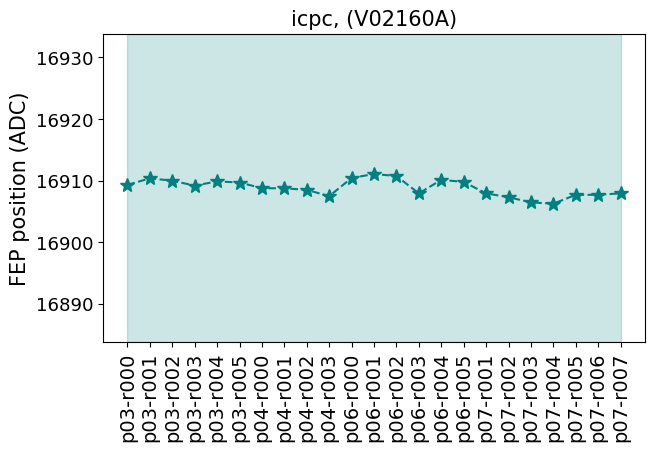

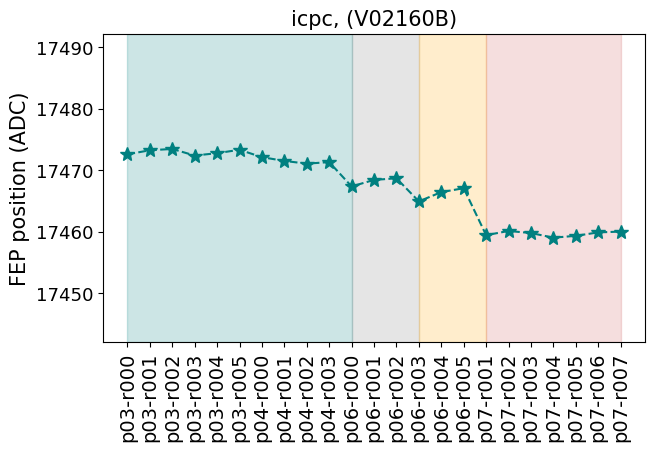

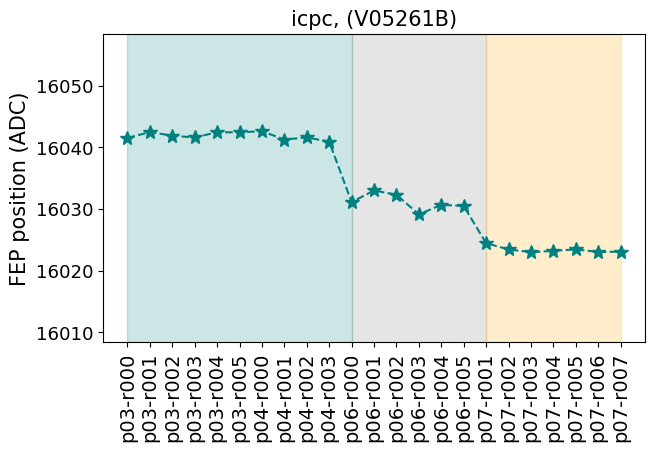

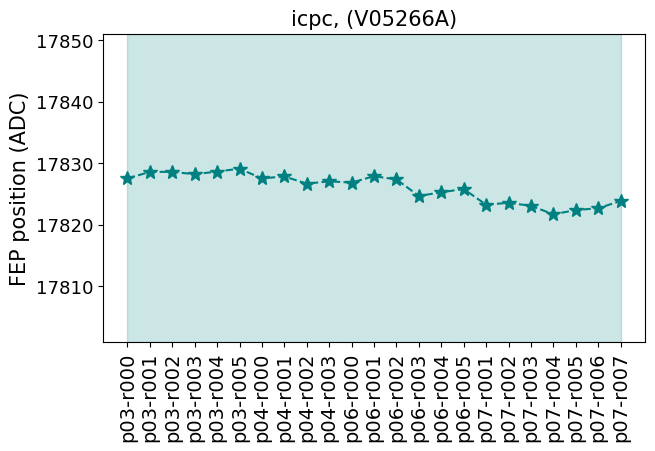

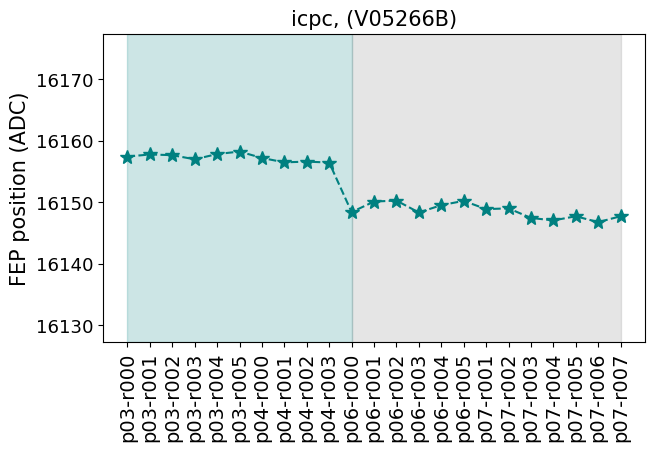

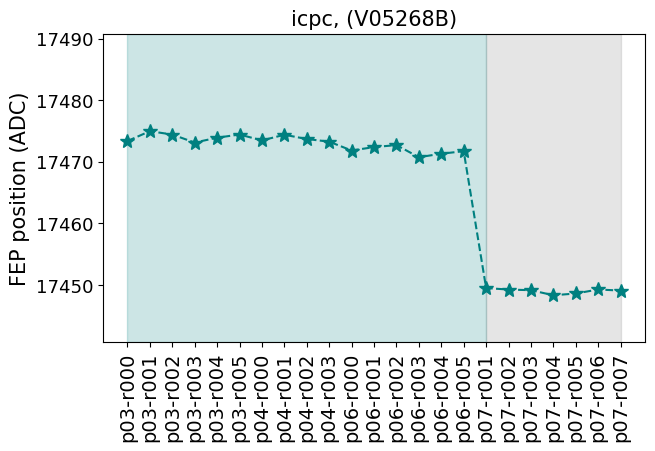

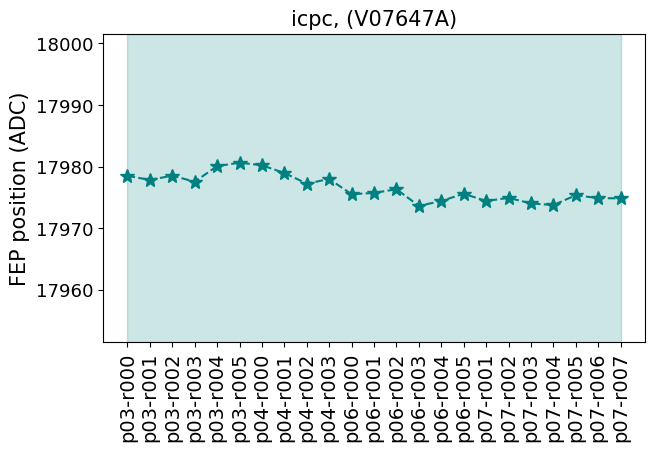

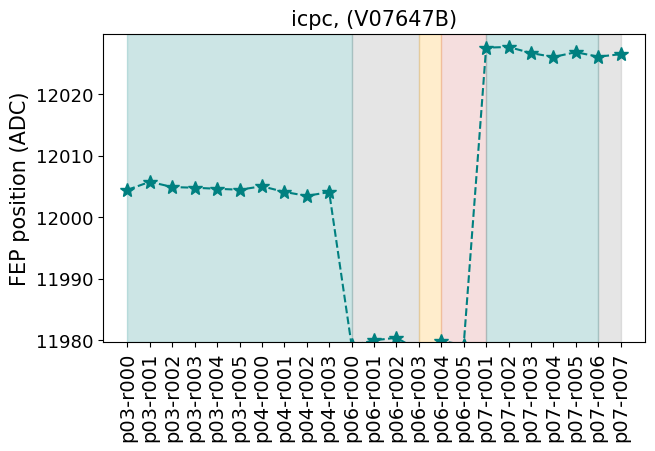

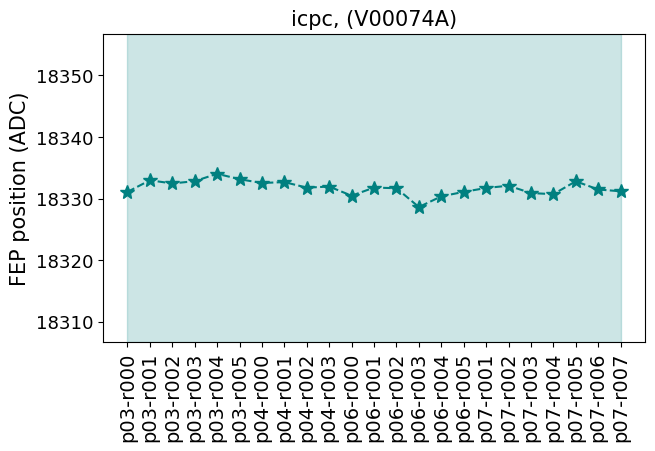

ch1108804
ch1115200
ch1115201
ch1115202


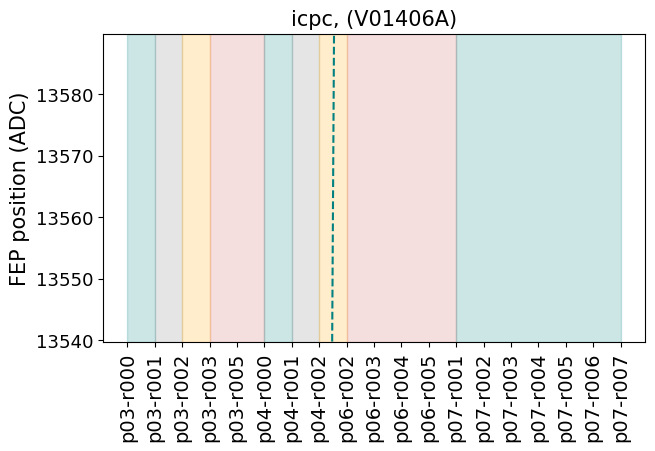

ch1115204


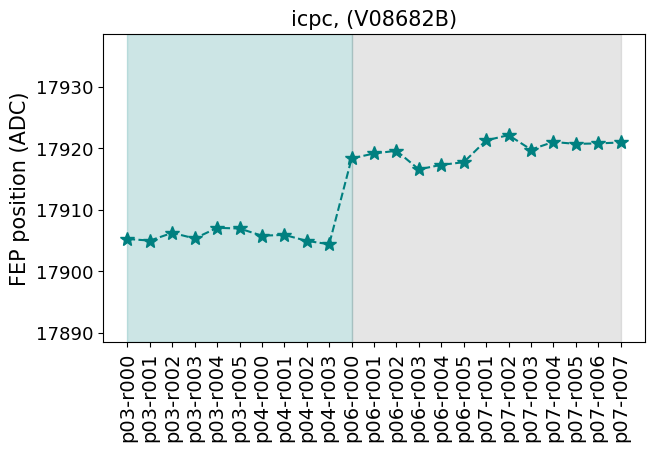

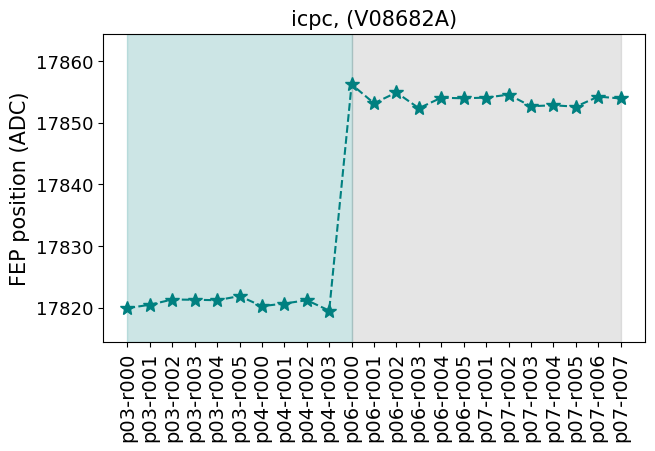

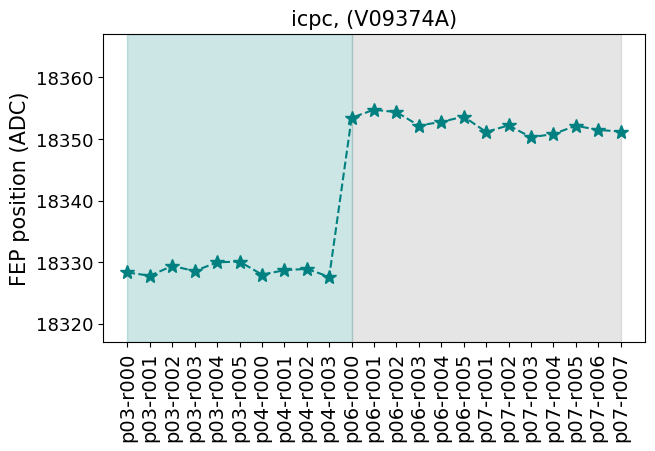

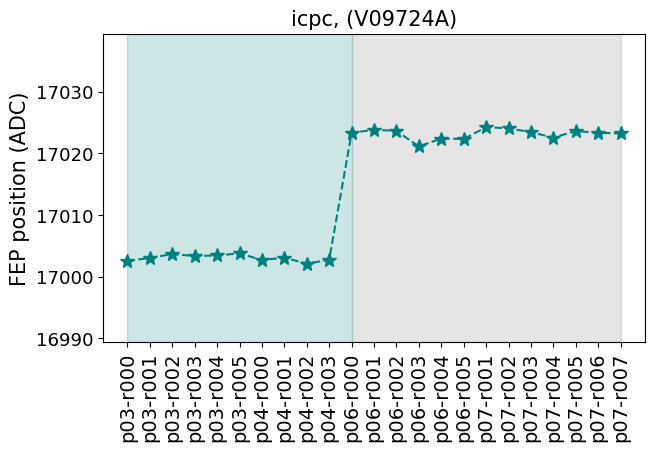

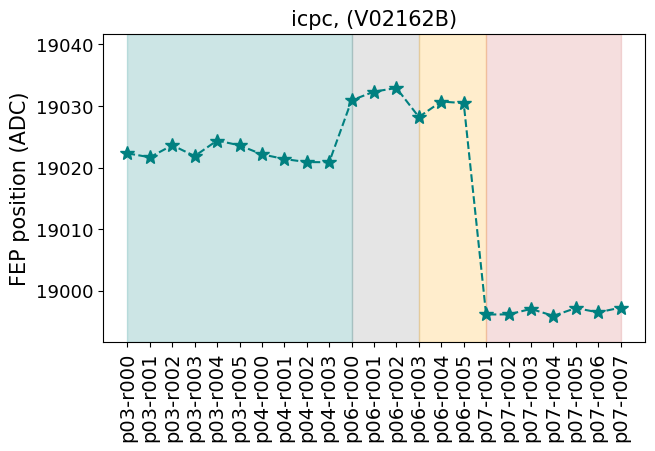

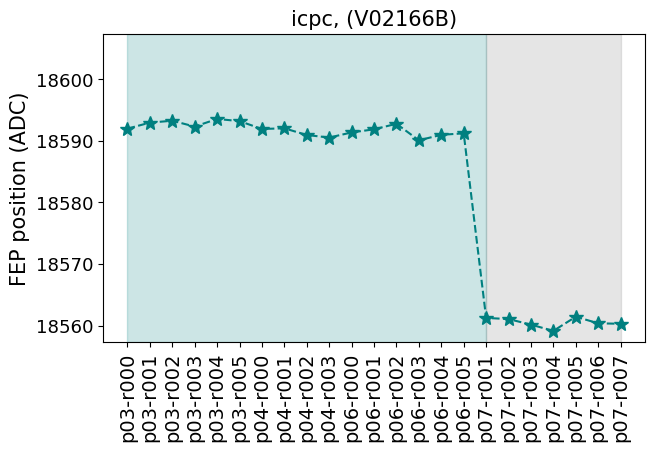

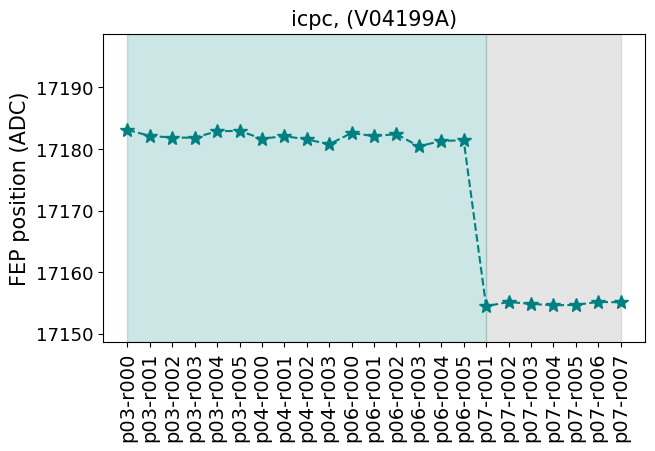

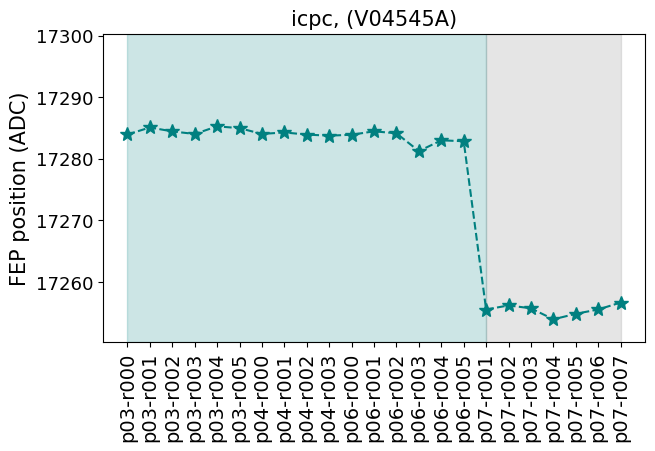

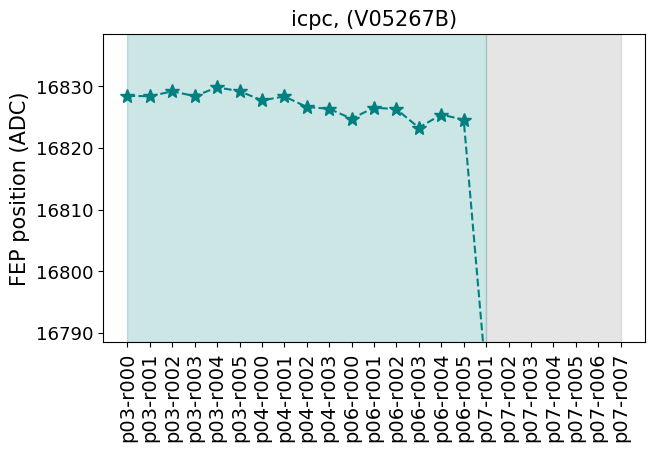

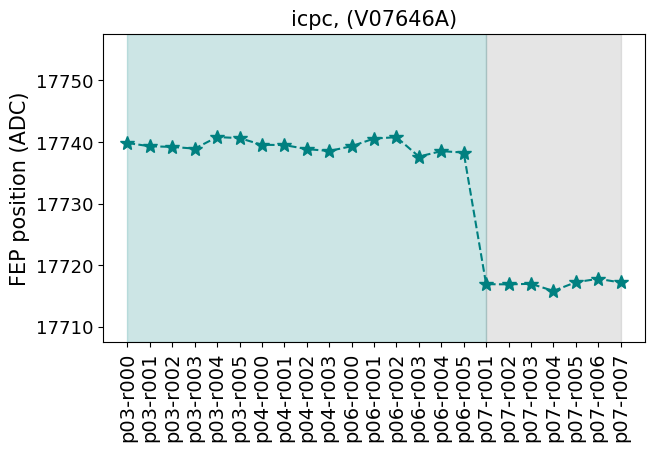

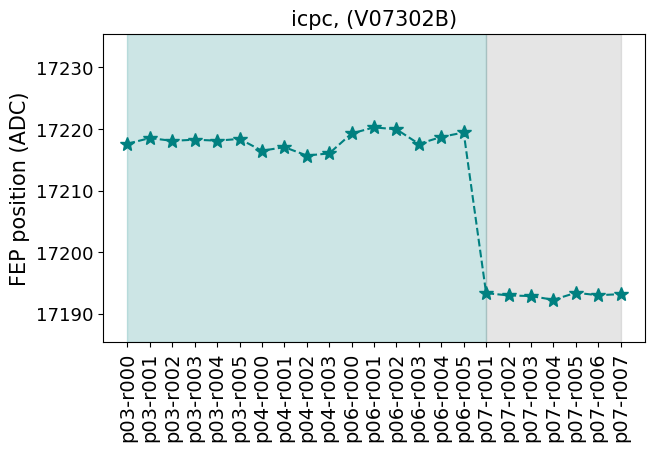

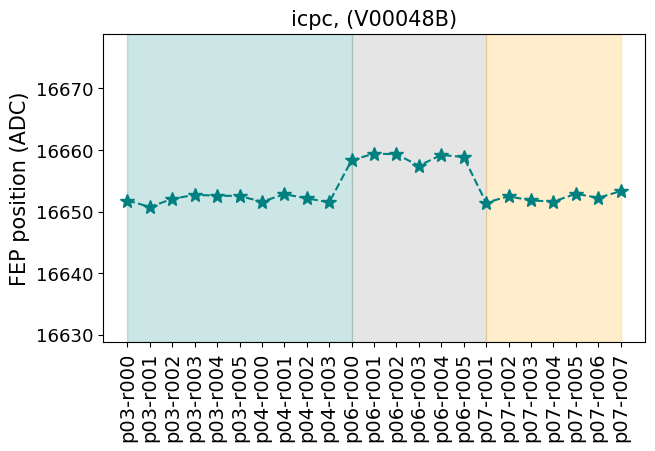

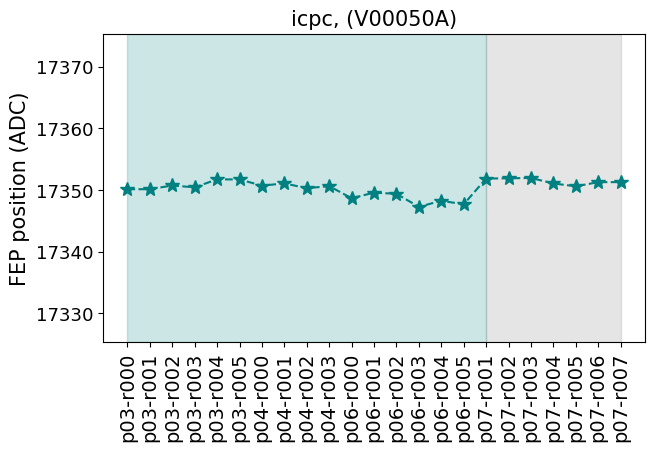

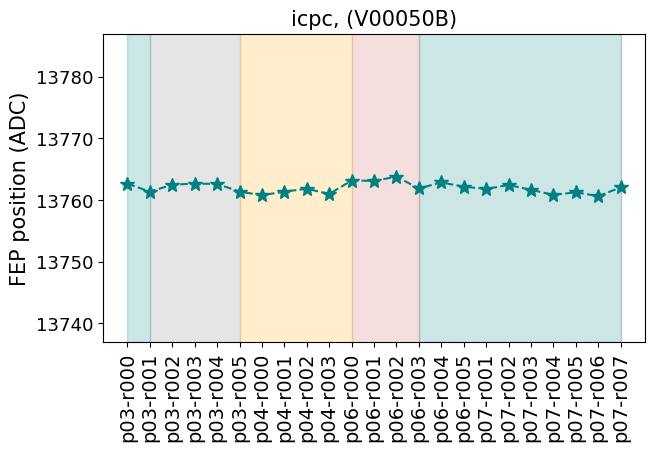

ch1121603


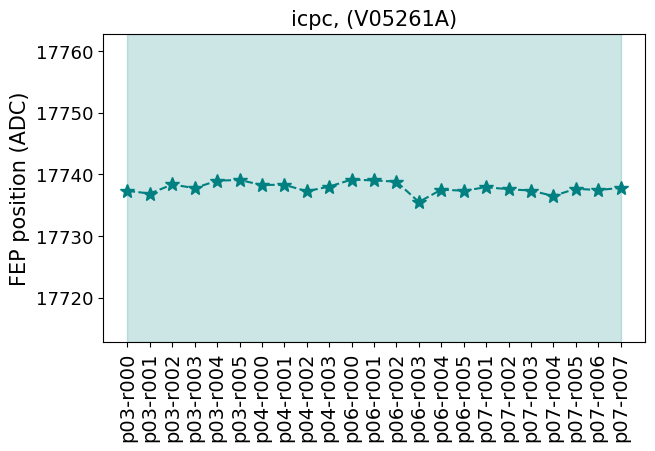

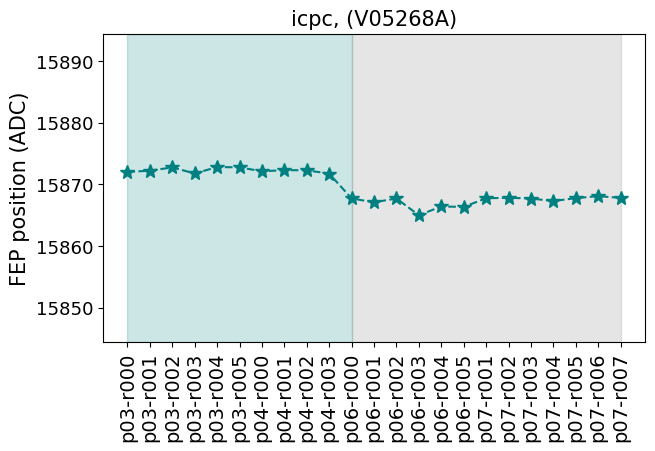

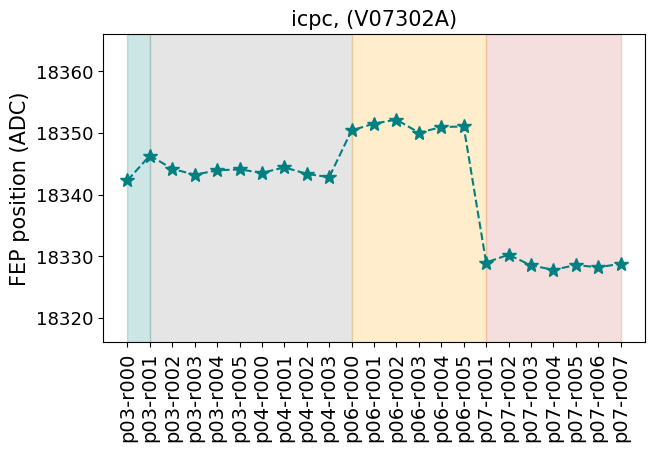

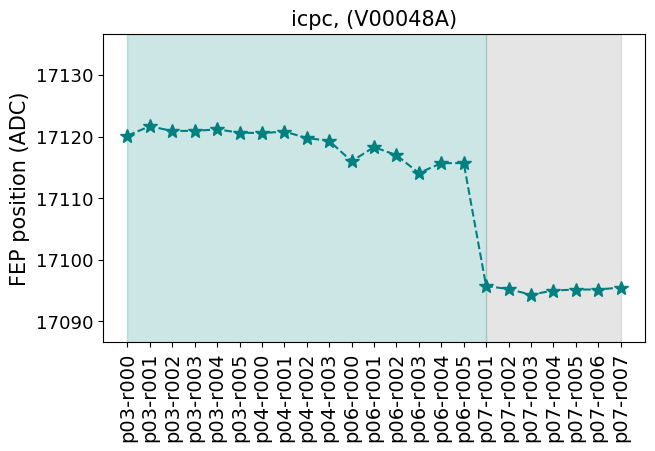

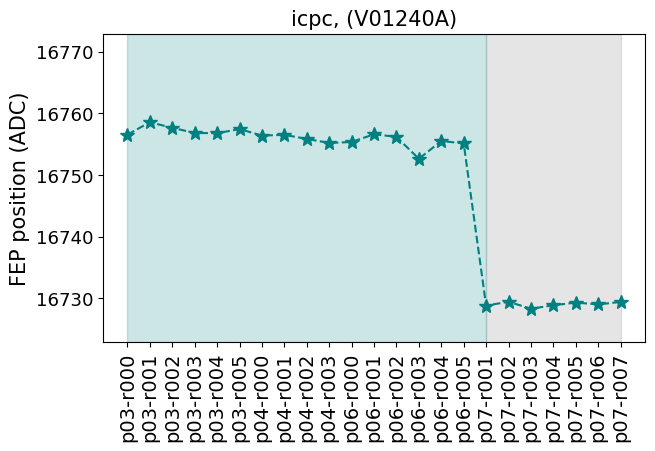

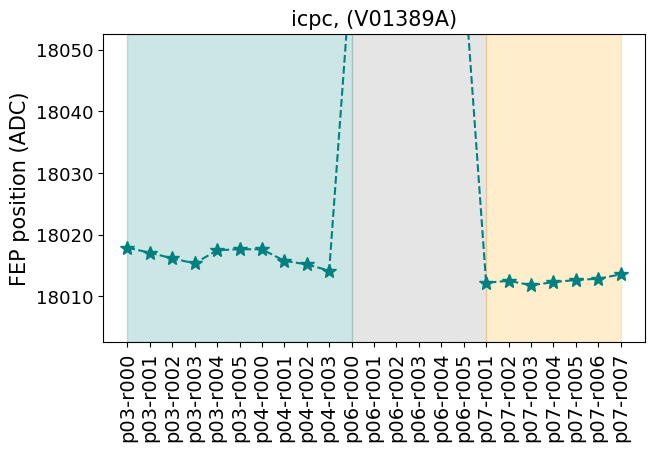

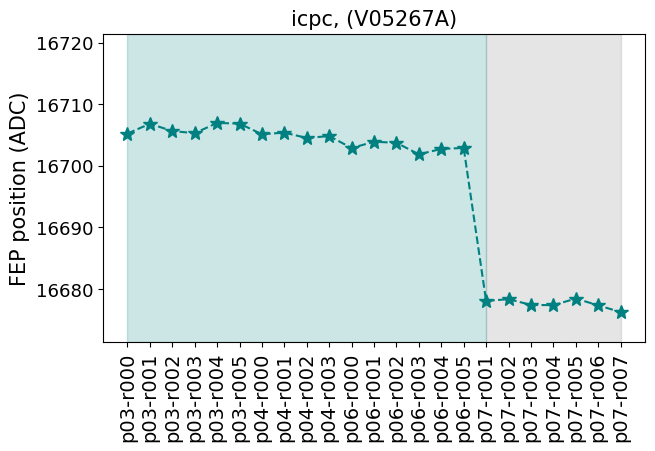

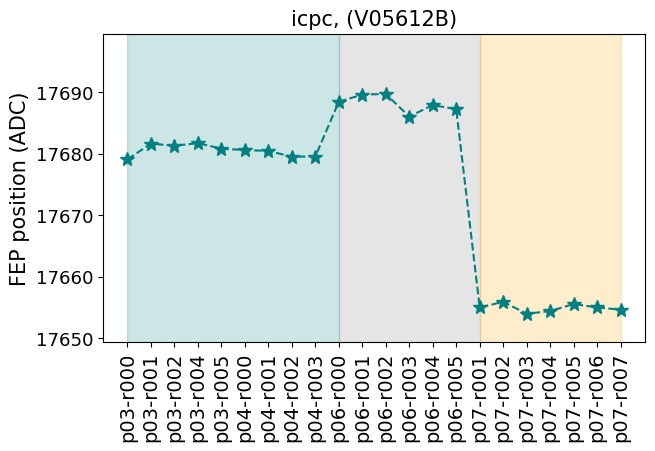

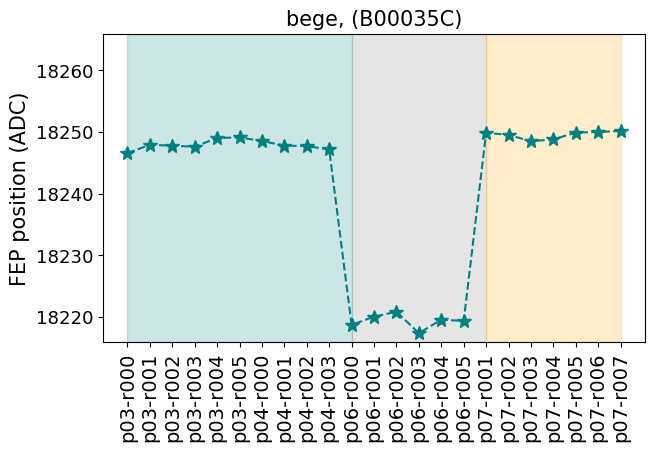

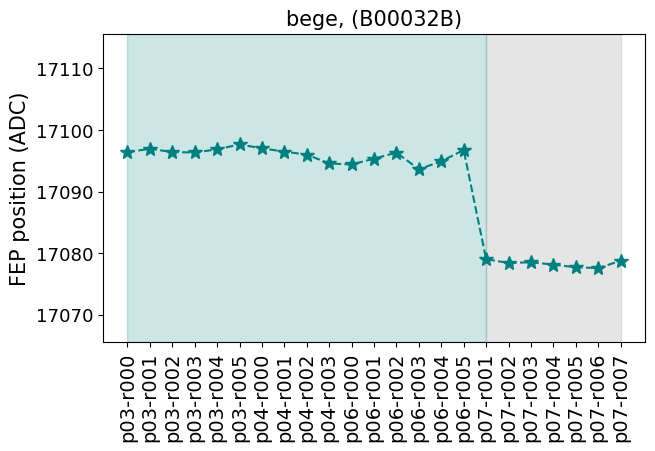

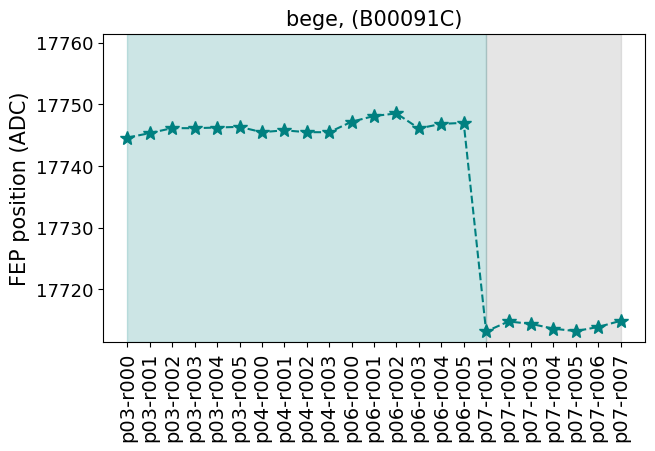

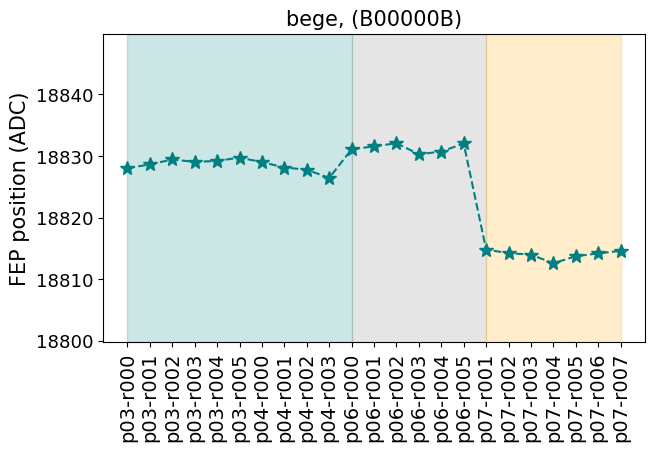

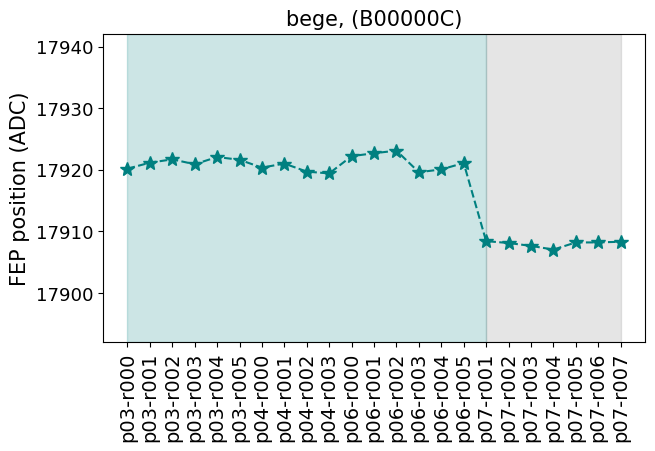

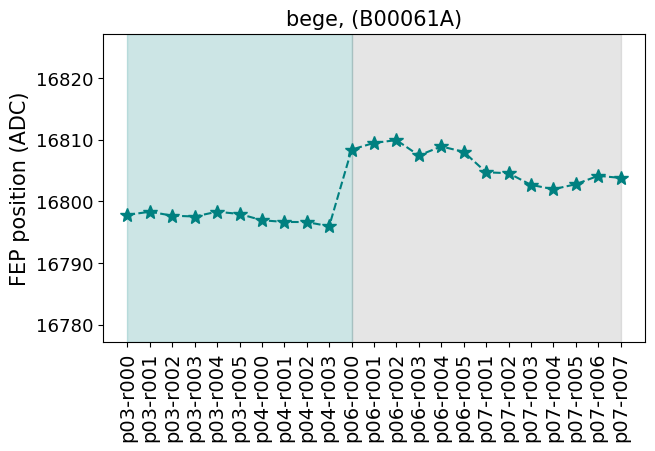

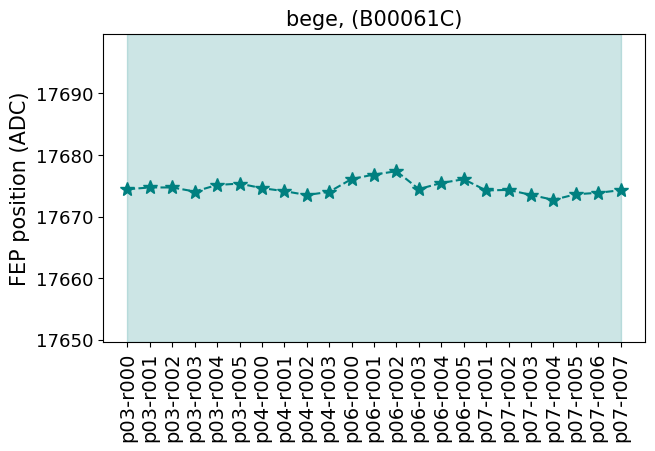

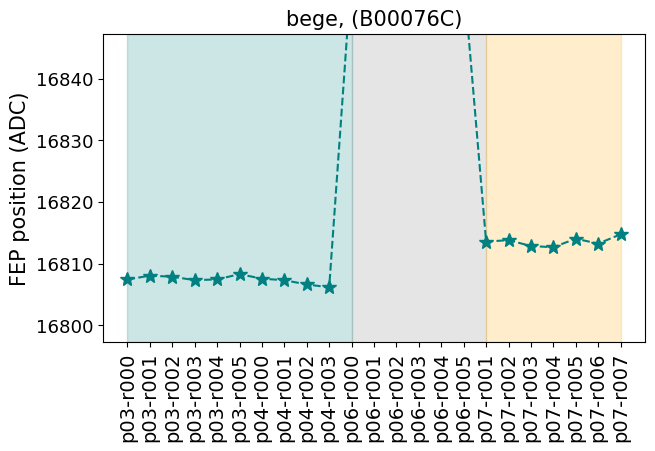

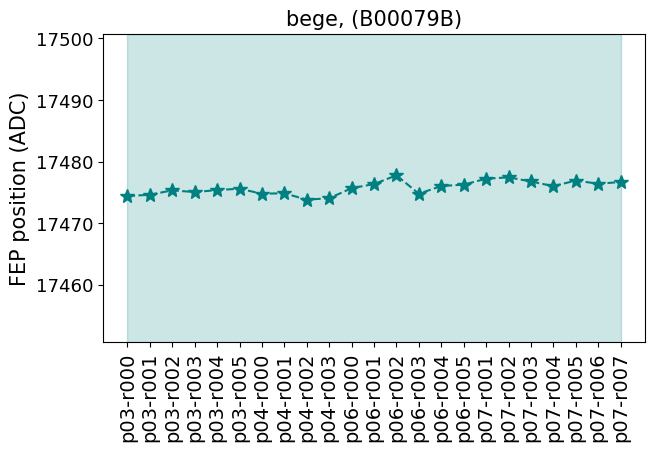

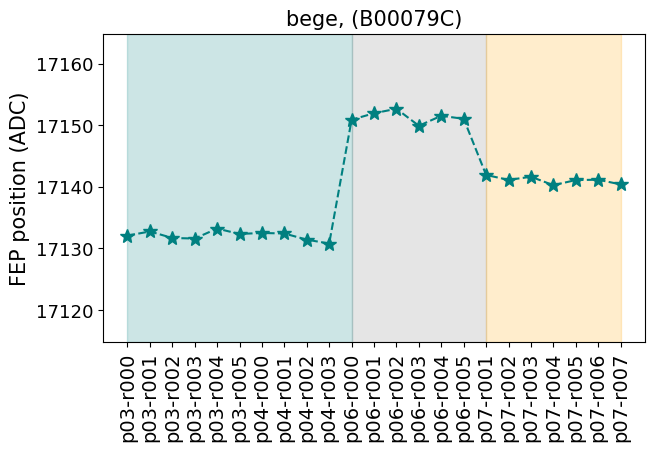

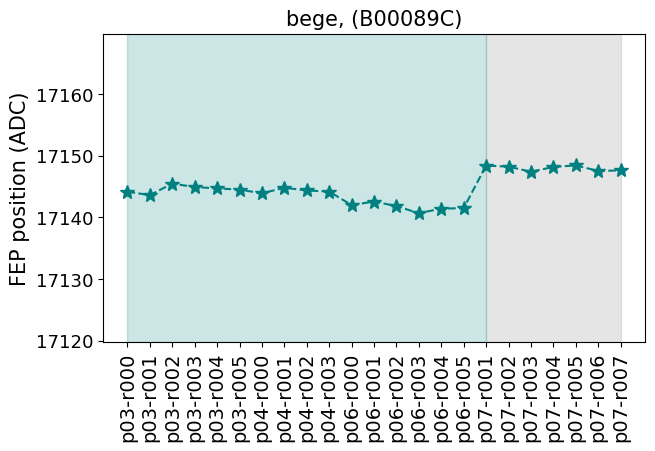

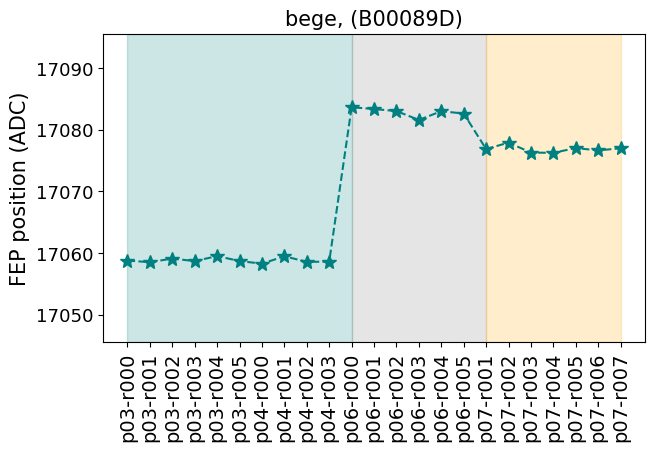

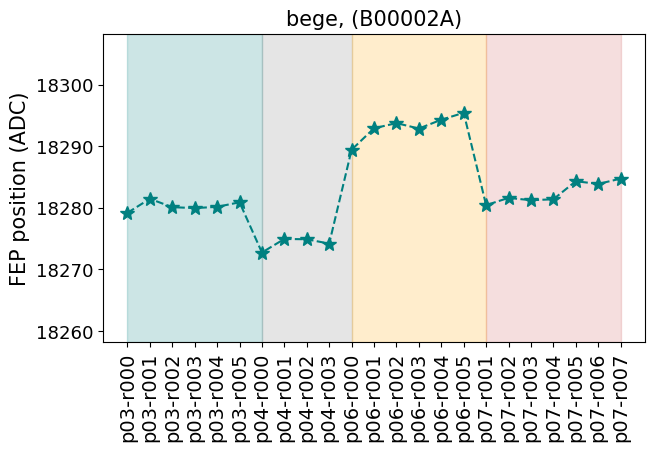

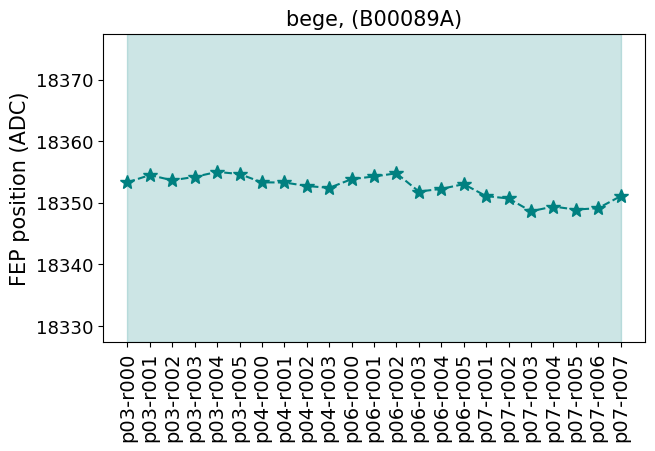

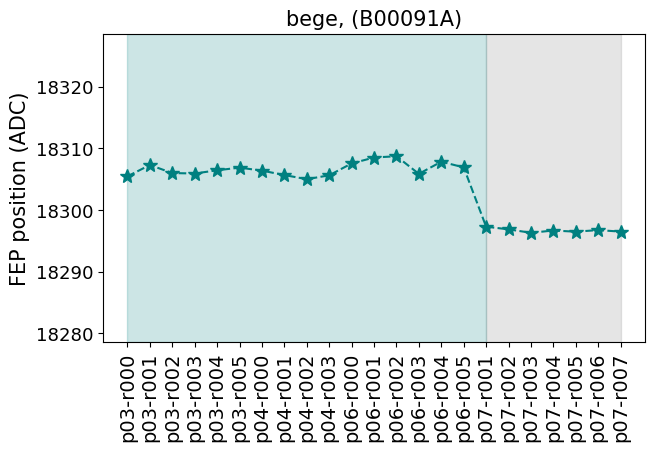

ch1080002
ch1083200


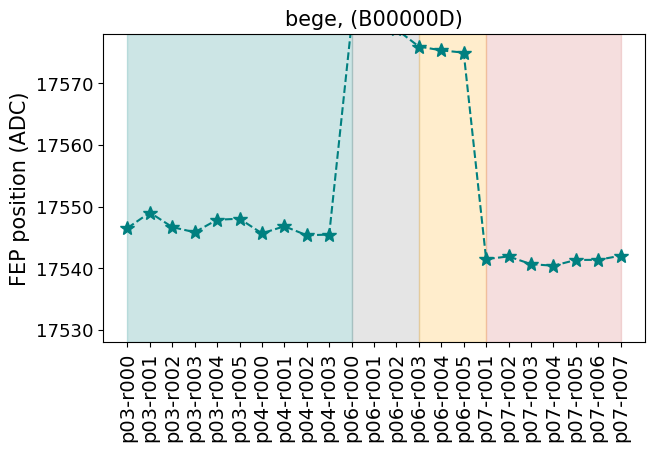

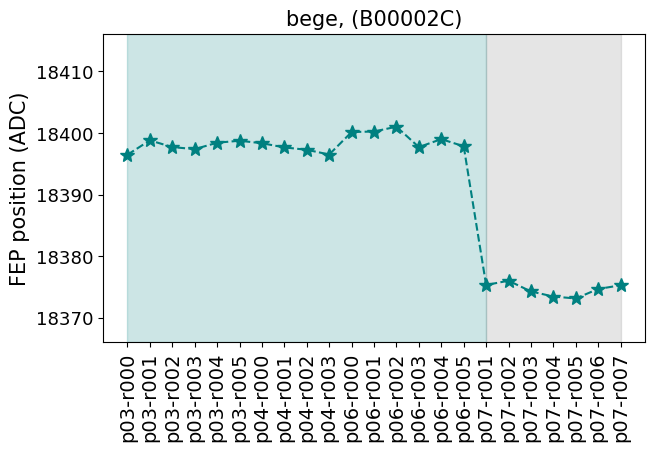

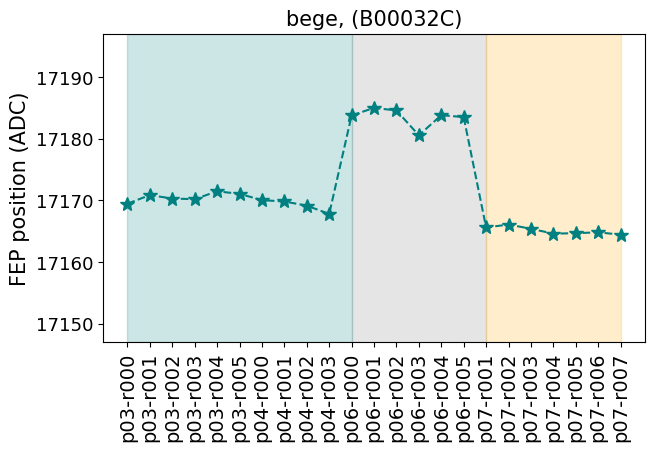

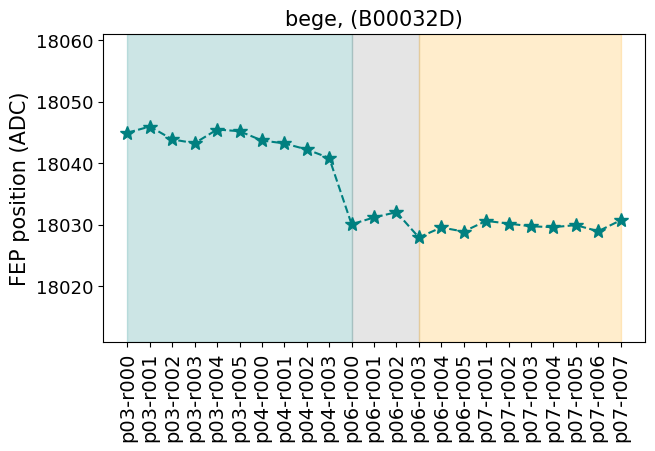

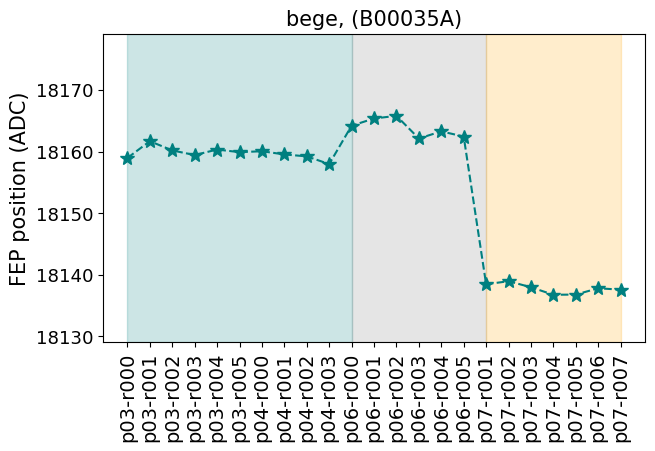

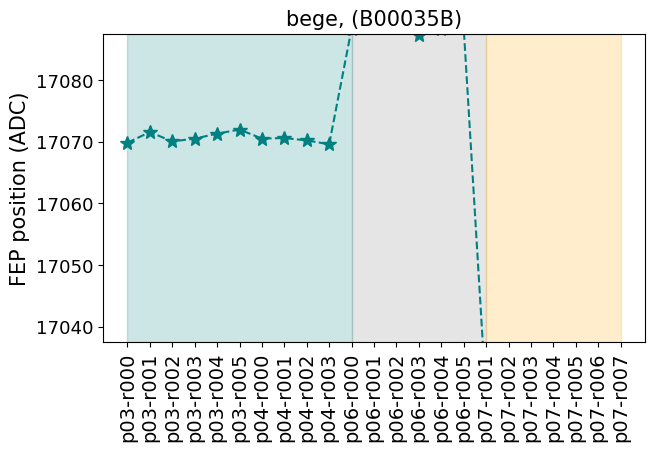

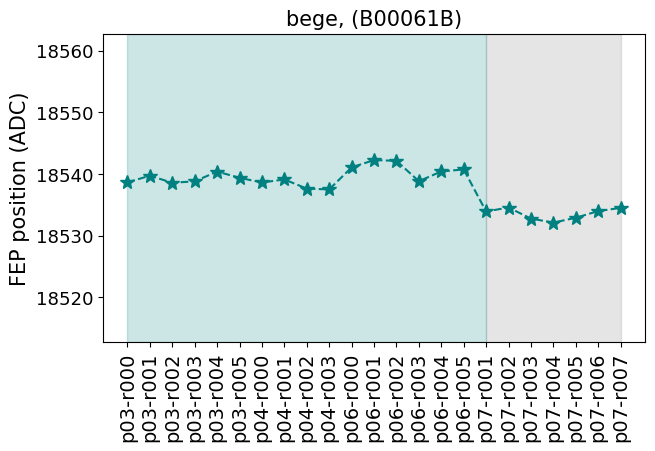

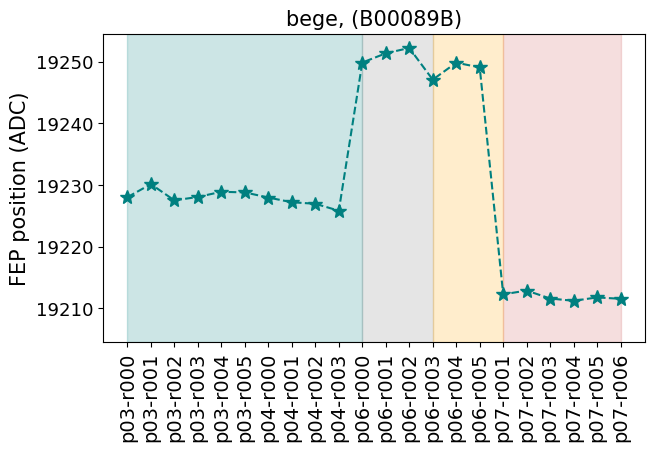

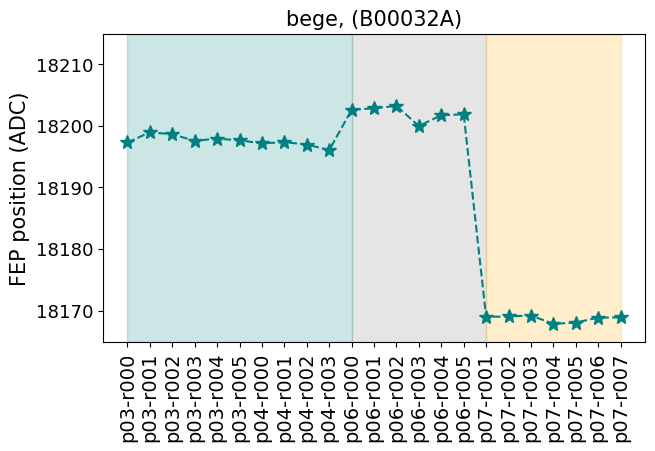

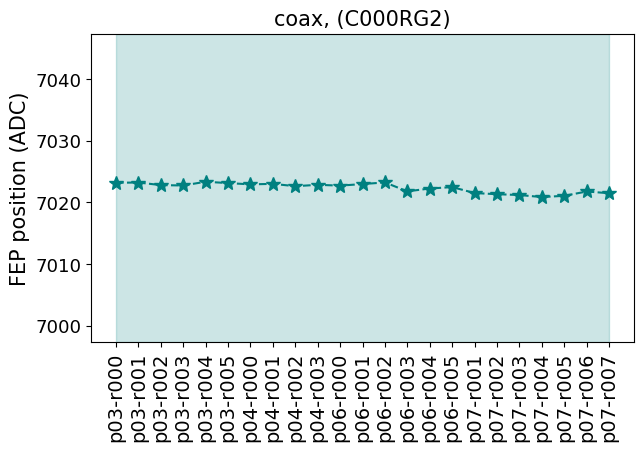

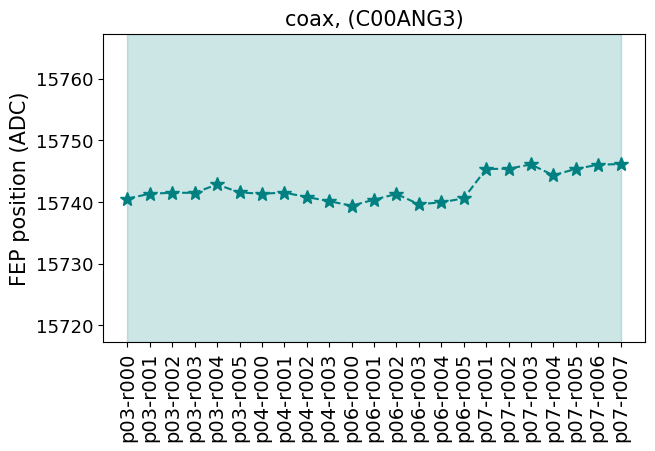

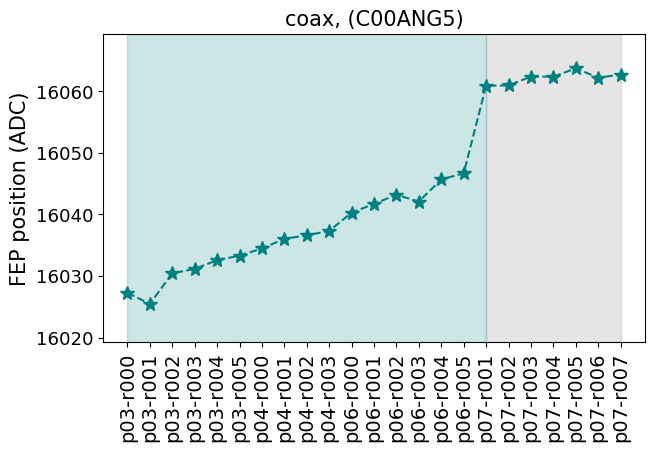

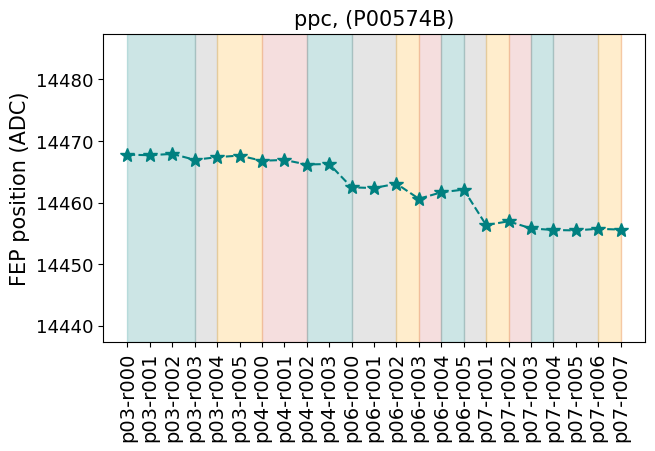

ch1110405


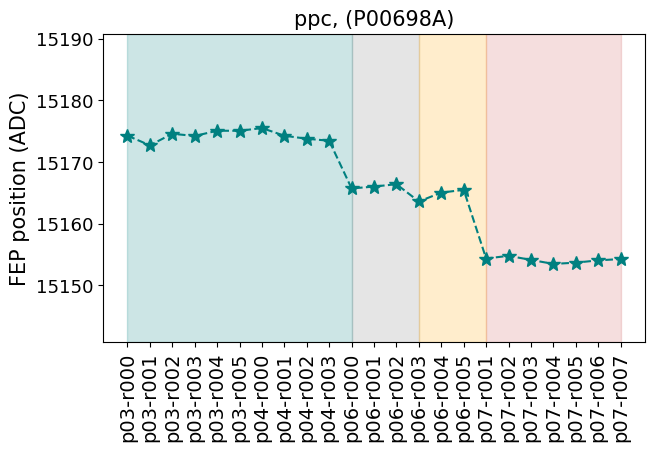

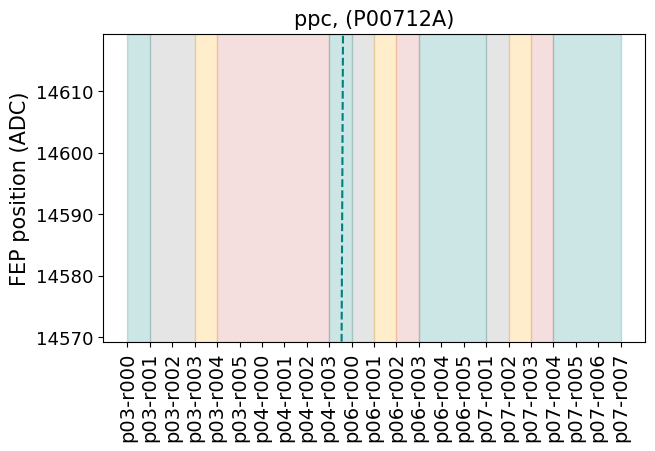

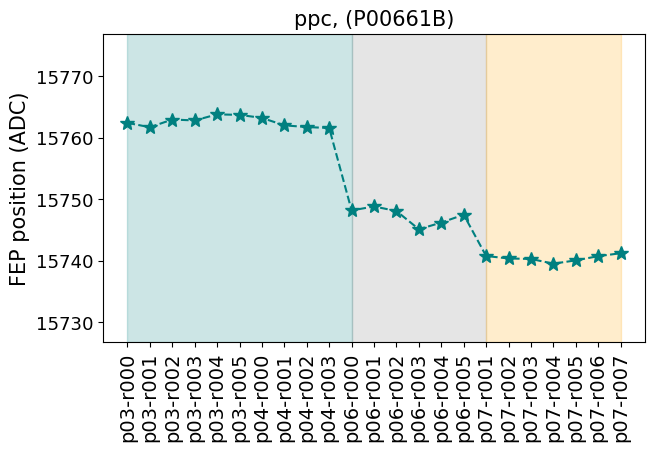

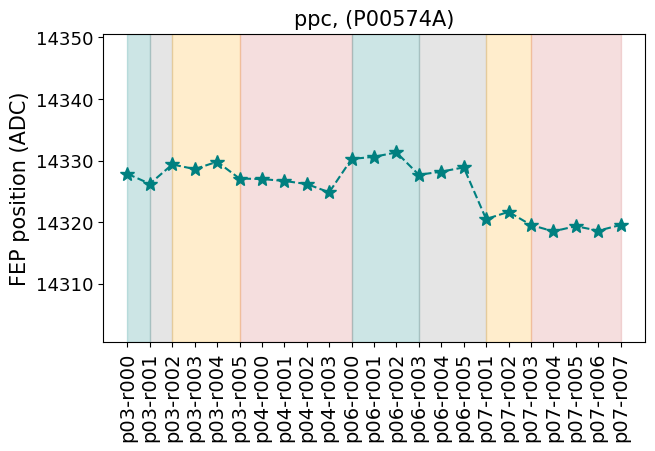

ch1080003


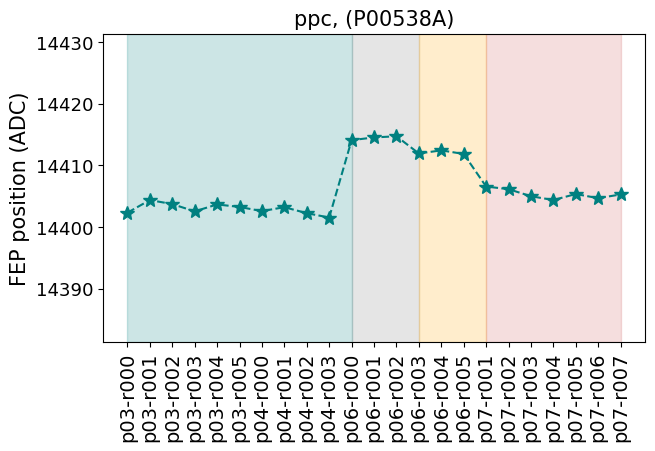

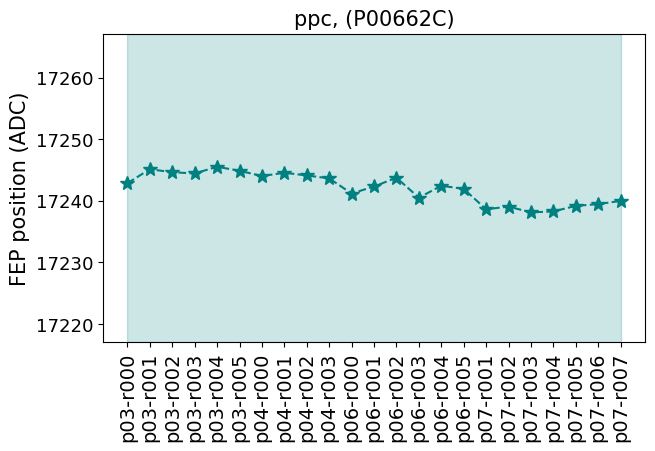

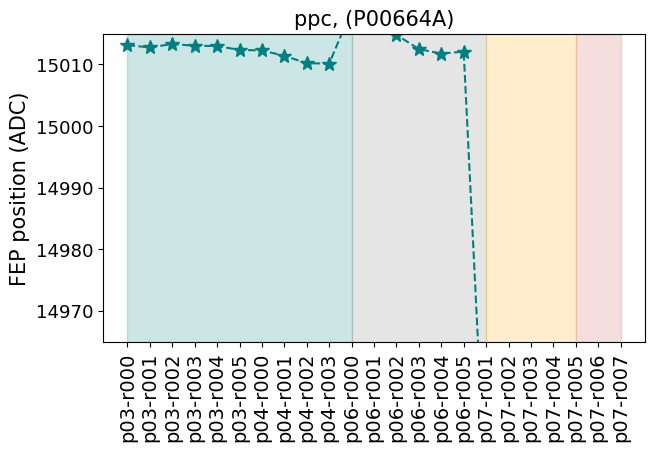

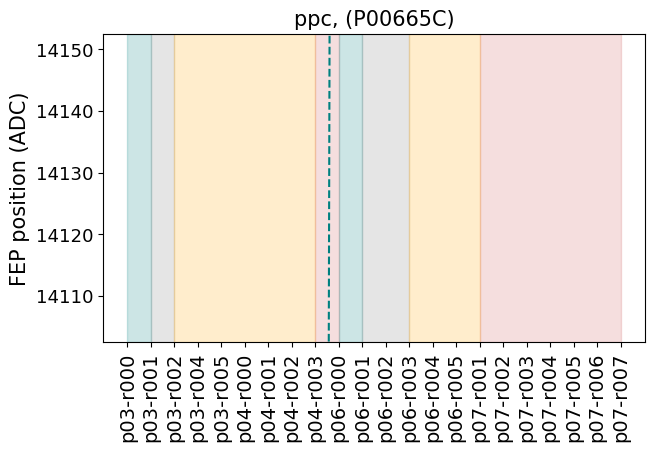

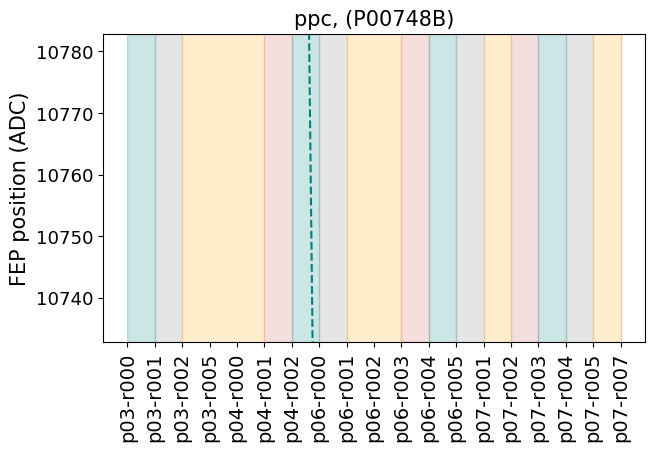

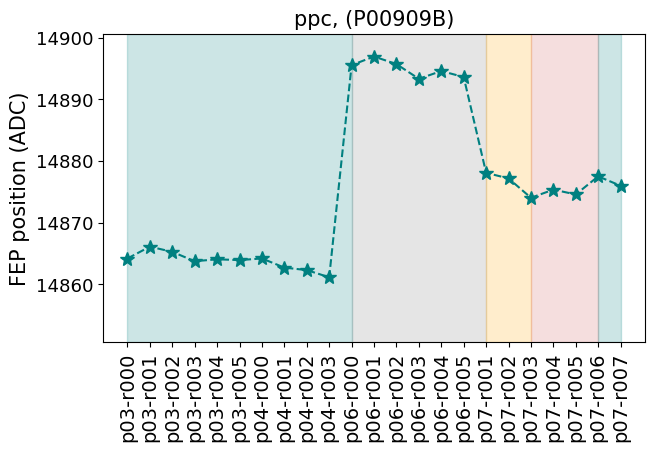

ch1088000


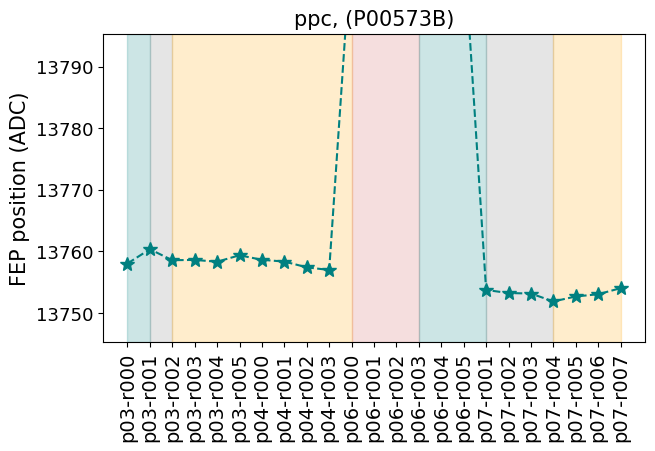

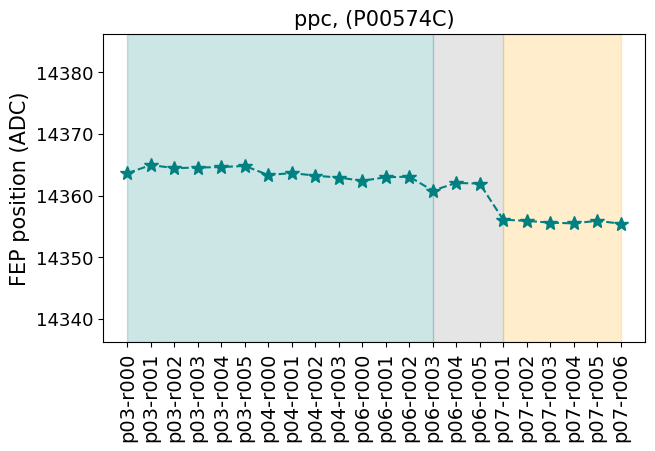

ch1088004


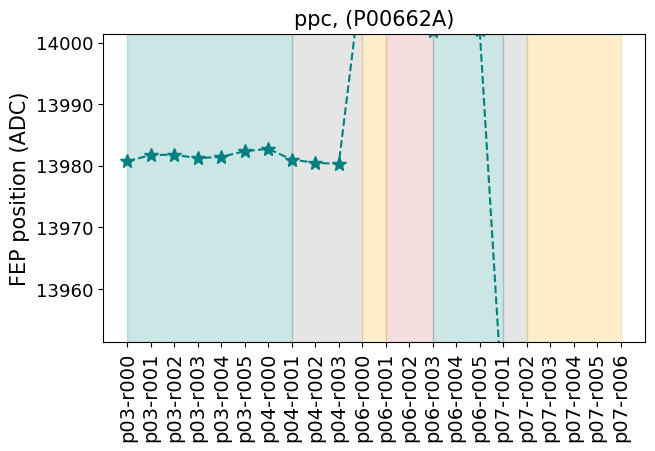

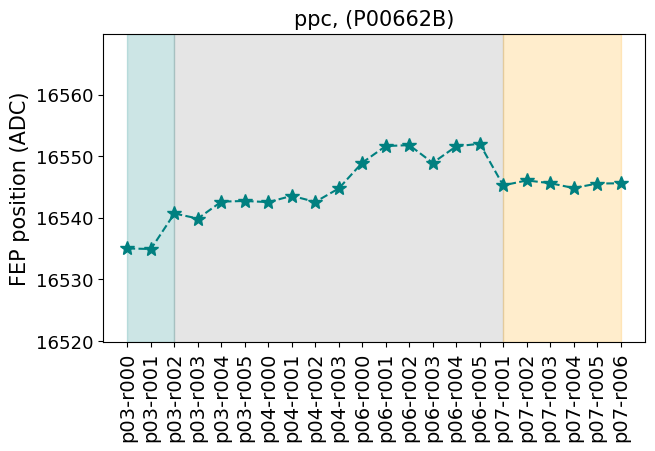

ch1089602


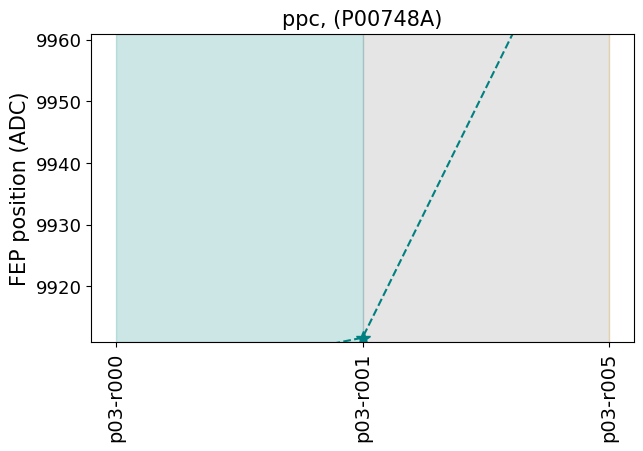

ch1089604


In [40]:
for channel in all_params_ch.keys():
    try:
        compute_and_plot_partition(channel, all_fitted_peaks[6])
    except KeyError:
        print(channel)
        continue

### Channels with high std in FEP position

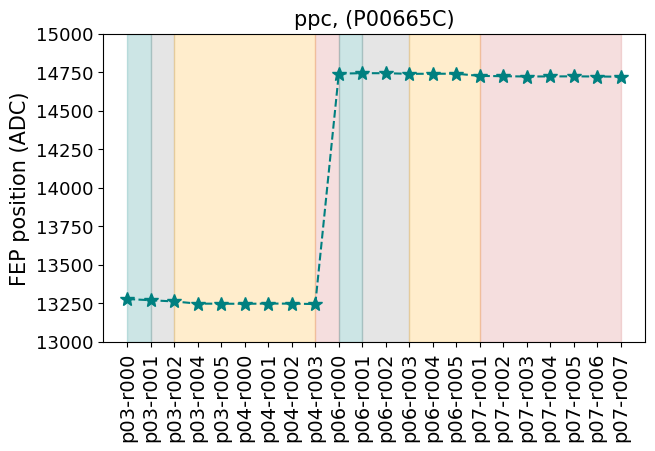

In [41]:
compute_and_plot_partition('ch1115203', all_fitted_peaks[6], ylim=(12800, 14100))
compute_and_plot_partition('ch1112001', all_fitted_peaks[6], ylim=(14000, 15100))
compute_and_plot_partition('ch1081603', all_fitted_peaks[6], ylim=(13000, 15000))
compute_and_plot_partition('ch1081604', all_fitted_peaks[6], ylim=(10500, 11200))